In [1]:
import itertools
import sys, os

import numpy as np
import pandas as pd
from scipy.special import comb
from scipy import stats
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
sns.set(rc={'figure.figsize':(15,8)})
sns.set_context('poster')
sns.set_style('white')


In [2]:
pd.options.display.float_format = '{:.2f}'.format


In [3]:
%load_ext autoreload
%autoreload 2
import CCPA_lib as cp


In [4]:
sns.set_context('poster')

In [5]:
pedge = 'green'
apallete = "spring"
aorder = ['DE', 'DE1', '1A3', 'ATCC', 'BS11']
amarkers = ['P', 'X', 'h', '<','>']
apallete = ['#6dad36', '#c7e89f', '#f5c4e1', '#d5579d', '#8a0850']

aedge='orange'
epallete = ['#6cf0ba', '#d13f75', '#eeb7cb', '#b9d2d8', '#407f90']
#sns.diverging_palette(355, 217, s=74, l=50, n=4) #'Paired' # 'BrBG'# "coolwarm"
eorder = ['e1','e3', 'e4', 'e5', 'e6']
#aedge='orange'

espallete = ['#6cf0ba', '#D55282', '#538B9B']

In [6]:
meta_df = pd.read_excel('exp 6 transfer Apr2019.xlsx', sheet_name='sent for seq')
meta_df.rename(columns={'#': 'sample_number'}, inplace=True)
meta_df.sample_number = pd.to_numeric(meta_df.sample_number)

In [7]:
pd.__version__

'1.2.3'

In [8]:
import json
with open(os.path.join('DNA','dnaseq', 'qualimap_multiqc_data','multiqc_data.json')) as fp:
    qualimap_json = json.load(fp)

In [9]:

qualimap_json.keys()

dict_keys(['report_data_sources', 'report_general_stats_data', 'report_general_stats_headers', 'report_multiqc_command', 'report_plot_data', 'report_saved_raw_data', 'config_analysis_dir_abs', 'config_analysis_dir', 'config_creation_date', 'config_git_hash', 'config_intro_text', 'config_report_comment', 'config_report_header_info', 'config_script_path', 'config_short_version', 'config_subtitle', 'config_title', 'config_version'])

In [10]:
qmap_titles = {i : qualimap_json['report_general_stats_headers'][0][i]['title'].replace('&ge;', '>')
 for i in qualimap_json['report_general_stats_headers'][0] }

In [11]:
len(qualimap_json['report_general_stats_data'])

1

In [12]:
def _item_to_dict(k,v):
    v['Key'] = k.split('|')[0]
    return v
bamqc_df = pd.DataFrame([_item_to_dict(k,v) for k,v in qualimap_json['report_general_stats_data'][0].items()])

In [13]:
bamqc_df.head()

,total_reads,mapped_reads,percentage_aligned,general_error_rate,mean_coverage,Key,median_coverage,median_insert_size,avg_gc,1_x_pc,5_x_pc,10_x_pc,30_x_pc,50_x_pc
0,550761.00,134228.00,24.37,0.44,4.86,12_1A3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,79690.00,9854.00,12.37,3.72,0.36,21_DE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,268388.00,54226.00,20.20,0.18,4.96,18_MIT0604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,221198.00,1103.00,0.50,11.42,0.04,17_Maricaulis,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,261903.00,251977.00,96.21,0.28,9.03,06_1A3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
bamqc_df = bamqc_df.pivot_table(index='Key').reset_index()
bamqc_df = bamqc_df.loc[~bamqc_df.Key.isin(['08_1A3', '08_MIT9313'])]
bamqc_df[['sample_number', 'species']] = bamqc_df.Key.str.split('_', expand=True)
bamqc_df['sample_number'] = pd.to_numeric(bamqc_df['sample_number'])
bamqc_df = bamqc_df.loc[bamqc_df.sample_number != 8]

bamqc_df.head()


,Key,10_x_pc,1_x_pc,30_x_pc,50_x_pc,5_x_pc,avg_gc,general_error_rate,mapped_reads,mean_coverage,median_coverage,median_insert_size,percentage_aligned,total_reads,sample_number,species
0,01_1A3,99.67,99.99,44.56,2.07,99.96,45.44,0.30,818317.00,29.09,28.00,153.00,99.58,821779.00,1,1A3
1,02_DE,99.53,99.95,42.84,1.03,99.87,45.55,0.52,741707.00,28.49,28.00,156.00,98.53,752769.00,2,DE
2,03_MIT9313,99.51,100.00,49.14,2.18,99.93,51.55,0.21,544213.00,29.70,29.00,114.00,98.87,550420.00,3,MIT9313
3,04_MIT0604,99.69,99.76,73.07,10.39,99.75,32.48,0.19,366615.00,36.21,36.00,160.00,68.25,537173.00,4,MIT0604
4,04_Maricaulis,0.00,0.85,0.00,0.00,0.00,60.34,11.37,404.00,0.02,0.00,148.00,0.25,163701.00,4,Maricaulis


In [15]:
bamqc_df = pd.merge(bamqc_df, meta_df, on='sample_number', how='left')

In [16]:
bamqc_df.columns

Index(['Key', '10_x_pc', '1_x_pc', '30_x_pc', '50_x_pc', '5_x_pc', 'avg_gc',
       'general_error_rate', 'mapped_reads', 'mean_coverage',
       'median_coverage', 'median_insert_size', 'percentage_aligned',
       'total_reads', 'sample_number', 'species', 'sample', 'PRO', 'ALT',
       'exp', 'days', 'ng/ul', 'final volume'],
      dtype='object')

In [17]:
value_cols = ['sample', 'PRO', 'ALT',
       'exp', '5_x_pc', '10_x_pc', '30_x_pc', 'avg_gc',
       
         'percentage_aligned','median_coverage','mean_coverage','median_insert_size',
        'general_error_rate', 'mapped_reads', 'total_reads'
             ]
        
pct_cols = [ '5_x_pc', '10_x_pc', '30_x_pc', 'avg_gc',
         'percentage_aligned']
with pd.ExcelWriter('bamqc_stats.xlsx', engine='xlsxwriter') as writer:  
    workbook  = writer.book
    format1 = workbook.add_format({'num_format': '#,##0.00'})
    format2 = workbook.add_format({'num_format': '0%'})
    for i in bamqc_df.species.unique():
        bamqc_pdf = bamqc_df.loc[bamqc_df.species.isin([i])].pivot(index='sample_number', columns='species', 
                               values=value_cols)
        bamqc_pdf[pct_cols] = bamqc_pdf[pct_cols]/100
        bamqc_pdf.rename(columns=qmap_titles, inplace=True)
        sheetname = f'{i} bamqc'
        bamqc_pdf.to_excel(writer, sheet_name=sheetname)
        worksheet = writer.sheets[sheetname]
        worksheet.set_column('F:J', None, format2)
        worksheet.set_column('L:L', None, format1)
        
        
        worksheet.conditional_format(f'F1:H{bamqc_df.shape[0]+2}', {'type': 'data_bar'})
        worksheet.conditional_format(f'K1:L{bamqc_df.shape[0]+2}', {'type': 'data_bar', 'bar_color' : 'green'})
    



PermissionError: [Errno 13] Permission denied: 'bamqc_stats.xlsx'

In [20]:
import json
with open(os.path.join('DNA','dnaseq_trimmed', 'multiqc_data.json')) as fp:
    qualimap_json = json.load(fp)

In [21]:
trimmed_titles = {i : qualimap_json['report_general_stats_headers'][0][i]['title'].replace('&ge;', '>')
 for i in qualimap_json['report_general_stats_headers'][0] }

In [22]:
len(qualimap_json['report_general_stats_data'])

4

In [23]:
def _item_to_dict(k,v):
    v['Key'] = k.split('|')[0]
    return v
trimmed_df = pd.DataFrame([
    _item_to_dict(k,v) 
    for d in qualimap_json['report_general_stats_data']
    for k,v in d.items()
])

In [24]:
trimmed_df.head()

,total_reads,mapped_reads,percentage_aligned,general_error_rate,mean_coverage,median_coverage,median_insert_size,avg_gc,1_x_pc,5_x_pc,...,forward_only_surviving_pct,reverse_only_surviving,reverse_only_surviving_pct,dropped,dropped_pct,percent_gc,avg_sequence_length,total_sequences,percent_duplicates,percent_fails
0,488749.00,8101.00,1.66,2.13,0.29,0.00,154.00,45.75,14.74,0.16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,65170.00,7893.00,12.11,2.10,0.28,0.00,154.00,45.67,14.52,0.12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,489657.00,15149.00,3.09,2.02,0.50,0.00,155.00,45.74,24.72,0.41,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,489977.00,1455.00,0.30,3.89,0.09,0.00,128.00,53.35,0.46,0.38,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,491414.00,420148.00,85.50,0.09,38.42,38.00,153.00,32.64,99.75,99.71,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
trimmed_df['Key'].unique()



array(['snippy_19_DE_all', 'snippy_19_DE_filtered', 'snippy_19_1A3_all',
       'snippy_19_MIT9313_all', 'snippy_19_MIT0604_all',
       'snippy_19_MIT0604_filtered', 'snippy_10_MIT9313_all',
       'snippy_10_MIT0604_filtered', 'snippy_10_MIT0604_all',
       'snippy_10_1A3_all', 'snippy_10_DE_all', 'snippy_10_1A3_filtered',
       'snippy_17_DE_filtered', 'snippy_17_DE_all',
       'snippy_17_MIT9313_all', 'snippy_17_MIT0604_filtered',
       'snippy_17_MIT0604_all', 'snippy_17_1A3_all',
       'snippy_13_MIT0604_all', 'snippy_13_MIT9313_all',
       'snippy_13_1A3_filtered', 'snippy_13_DE_all', 'snippy_13_1A3_all',
       'snippy_13_MIT0604_filtered', 'snippy_11_MIT0604_all',
       'snippy_11_1A3_all', 'snippy_11_MIT0604_filtered',
       'snippy_11_1A3_filtered', 'snippy_11_DE_all',
       'snippy_11_MIT9313_all', 'snippy_20_DE_filtered',
       'snippy_20_MIT0604_all', 'snippy_20_1A3_all',
       'snippy_20_MIT0604_filtered', 'snippy_20_DE_all',
       'snippy_20_MIT9313_all', 's

In [26]:
def _key_to_sample_species(x):
    mode = None
    if x.startswith('200219Seg_D20-16'):
        idx = x.replace('200219Seg_D20-', '').replace('_1_sequence','')
        sample_number = pd.to_numeric(idx) - 160000
        command = 'fastqc'
        species = None
    elif x.startswith('trim_200219Seg_D20'):
        idx = x.replace('trim_200219Seg_D20-', '').replace('_1_sequence_P','').replace('_2_sequence_P','')
        sample_number = pd.to_numeric(idx) - 160000
        command = 'trimmomatic'
        species = None
    elif x.startswith('freebayes_'):
        sample_number = None
        command = 'freebayes'
        species = x.replace('freebayes_', '')
    elif x.startswith('snippy_'):
        _, idx, species, mode = x.split('_')
        sample_number = pd.to_numeric(idx) 
        command = 'bamqc'
    return pd.Series({
        'species' : species,
         'mode' :mode,
        'sample_number' :sample_number,
        'command' : command,
    })

trimmed_df = pd.concat([trimmed_df, trimmed_df['Key'].apply(_key_to_sample_species)], axis=1)


In [27]:
trimmed_df = trimmed_df.loc[trimmed_df['sample_number'] != 8]

In [28]:
trimmed_df = pd.merge(trimmed_df, meta_df, on='sample_number', how='left')

In [29]:
trimmed_df['pair'] = trimmed_df['PRO'] + ',' + trimmed_df['ALT']

In [30]:
trimmed_df['Sample_Name'] = trimmed_df['pair'] + ' ' + trimmed_df['days'].astype(str) + ' ' + trimmed_df['sample']

In [31]:
trimmed_df.columns

Index(['total_reads', 'mapped_reads', 'percentage_aligned',
       'general_error_rate', 'mean_coverage', 'median_coverage',
       'median_insert_size', 'avg_gc', '1_x_pc', '5_x_pc',
       ...
       'command', 'sample', 'PRO', 'ALT', 'exp', 'days', 'ng/ul',
       'final volume', 'pair', 'Sample_Name'],
      dtype='object', length=121)

In [32]:
trimmed_df.head()

,total_reads,mapped_reads,percentage_aligned,general_error_rate,mean_coverage,median_coverage,median_insert_size,avg_gc,1_x_pc,5_x_pc,...,command,sample,PRO,ALT,exp,days,ng/ul,final volume,pair,Sample_Name
0,488749.00,8101.00,1.66,2.13,0.29,0.00,154.00,45.75,14.74,0.16,...,bamqc,10B,MIT0604,DE,6,440,6.25,100,"MIT0604,DE","MIT0604,DE 440 10B"
1,65170.00,7893.00,12.11,2.10,0.28,0.00,154.00,45.67,14.52,0.12,...,bamqc,10B,MIT0604,DE,6,440,6.25,100,"MIT0604,DE","MIT0604,DE 440 10B"
2,489657.00,15149.00,3.09,2.02,0.50,0.00,155.00,45.74,24.72,0.41,...,bamqc,10B,MIT0604,DE,6,440,6.25,100,"MIT0604,DE","MIT0604,DE 440 10B"
3,489977.00,1455.00,0.30,3.89,0.09,0.00,128.00,53.35,0.46,0.38,...,bamqc,10B,MIT0604,DE,6,440,6.25,100,"MIT0604,DE","MIT0604,DE 440 10B"
4,491414.00,420148.00,85.50,0.09,38.42,38.00,153.00,32.64,99.75,99.71,...,bamqc,10B,MIT0604,DE,6,440,6.25,100,"MIT0604,DE","MIT0604,DE 440 10B"


In [56]:
bamqc_df[['sample_number', 'total_reads']]
trimmed_df.loc[trimmed_df['mode'].isin(['all'])& 
               ((trimmed_df['species'] == trimmed_df.ALT) |(trimmed_df['species'] == trimmed_df.PRO))
               ,['sample_number', 'pair', 'days', 'total_reads','species', 'mapped_reads', 'percentage_aligned','mean_coverage', '10_x_pc',]
              ].dropna(subset=['total_reads']).drop_duplicates().sort_values('sample_number').to_excel('5x5 DNA stats.xlsx')


In [47]:
trimmed_df[['total_reads', 'mapped_reads', 'percentage_aligned',
       'general_error_rate', 'mean_coverage', 'median_coverage','10_x_pc',
           'Genome','species', 'mode' ]]

,total_reads,mapped_reads,percentage_aligned,general_error_rate,mean_coverage,median_coverage,10_x_pc,Genome,species,mode
0,488749.00,8101.00,1.66,2.13,0.29,0.00,0.00,NaN,DE,all
1,65170.00,7893.00,12.11,2.10,0.28,0.00,0.00,NaN,DE,filtered
2,489657.00,15149.00,3.09,2.02,0.50,0.00,0.00,NaN,1A3,all
3,489977.00,1455.00,0.30,3.89,0.09,0.00,0.33,NaN,MIT9313,all
4,491414.00,420148.00,85.50,0.09,38.42,38.00,99.25,NaN,MIT0604,all
...,...,...,...,...,...,...,...,...,...,...
171,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
172,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
173,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
174,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
trimmed_df.columns.values

array(['total_reads', 'mapped_reads', 'percentage_aligned',
       'general_error_rate', 'mean_coverage', 'median_coverage',
       'median_insert_size', 'avg_gc', '1_x_pc', '5_x_pc', '10_x_pc',
       '30_x_pc', '50_x_pc', 'Key', 'Genome',
       'Number_of_variants_before_filter',
       'Number_of_known_variants (i.e. non-empty ID)',
       'Number_of_known_variants (i.e. non-empty ID)_percent',
       'Number_of_effects', 'Genome_total_length',
       'Genome_effective_length', 'Change_rate', 'HIGH', 'HIGH_percent',
       'MODERATE', 'MODERATE_percent', 'MODIFIER', 'MODIFIER_percent',
       'MISSENSE', 'MISSENSE_percent', 'NONSENSE', 'NONSENSE_percent',
       'Missense_Silent_ratio', 'Type', 'downstream_gene_variant',
       'downstream_gene_variant_percent', 'intragenic_variant',
       'intragenic_variant_percent', 'missense_variant',
       'missense_variant_percent', 'non_coding_transcript_variant',
       'non_coding_transcript_variant_percent', 'stop_gained',
       'stop_

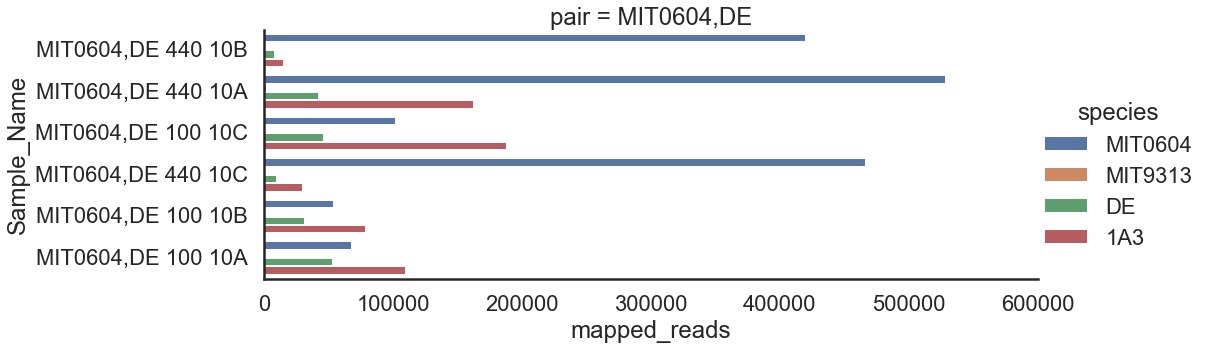

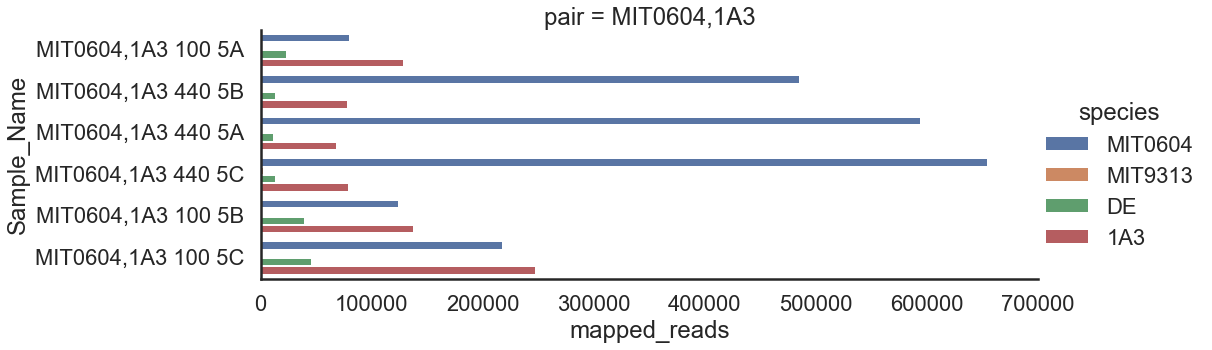

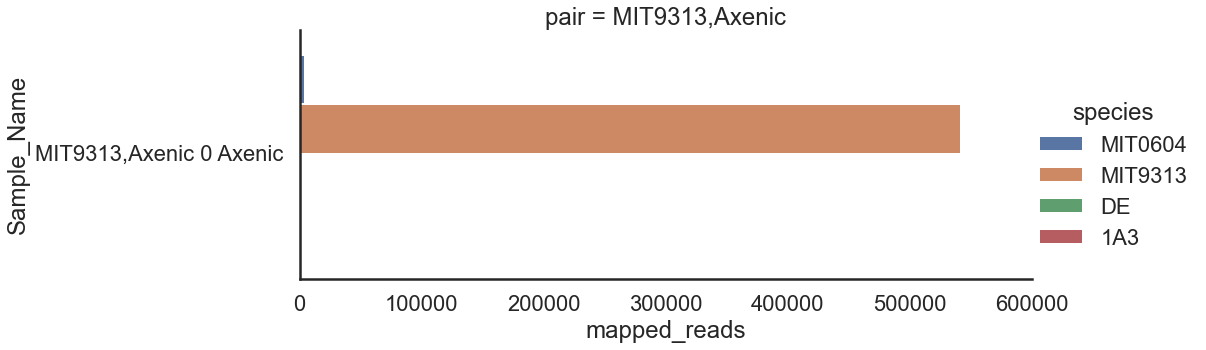

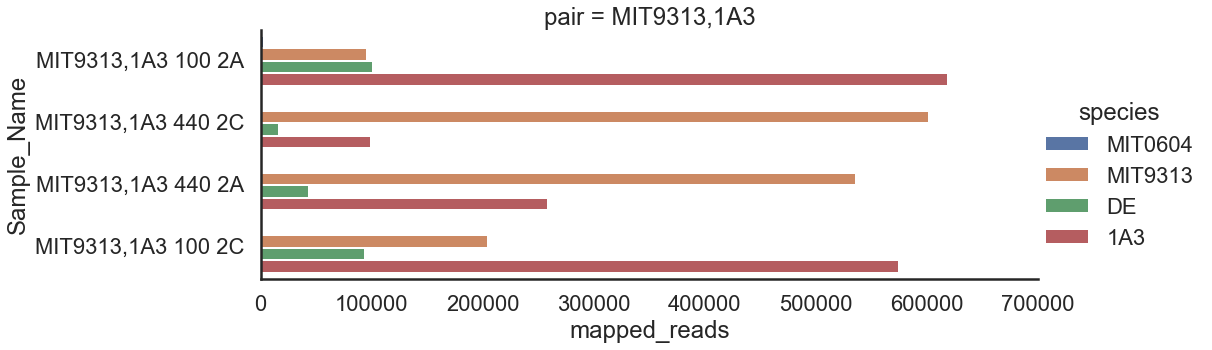

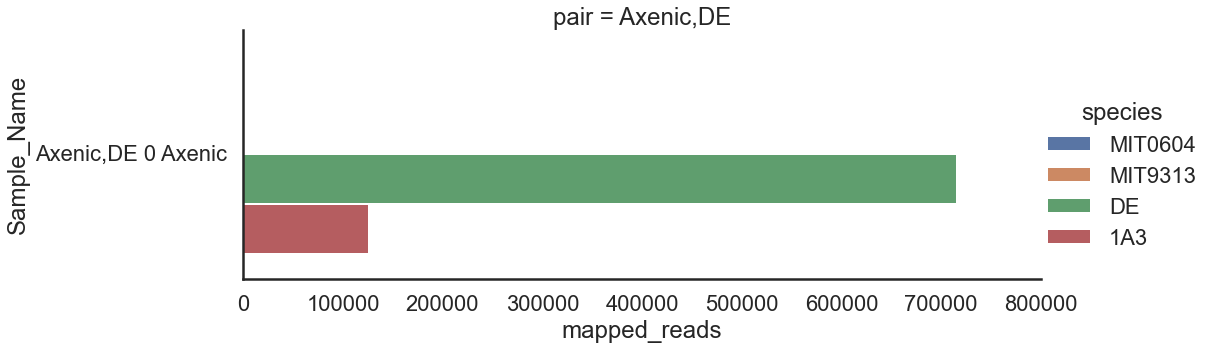

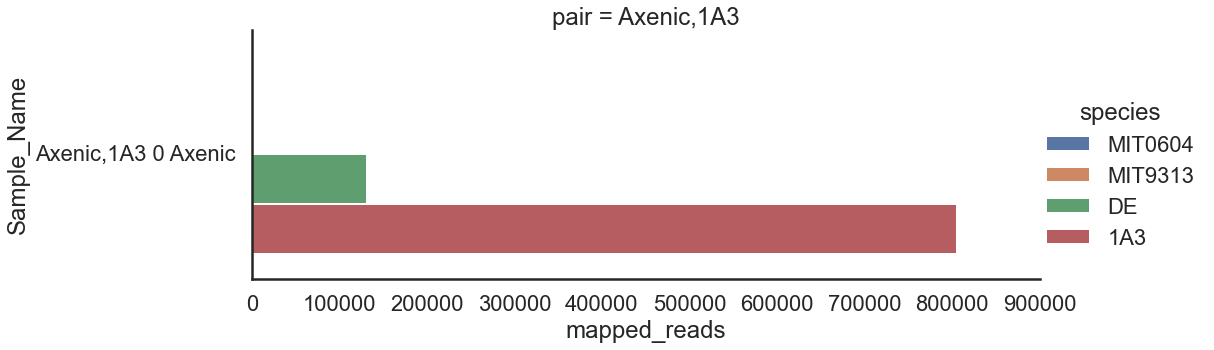

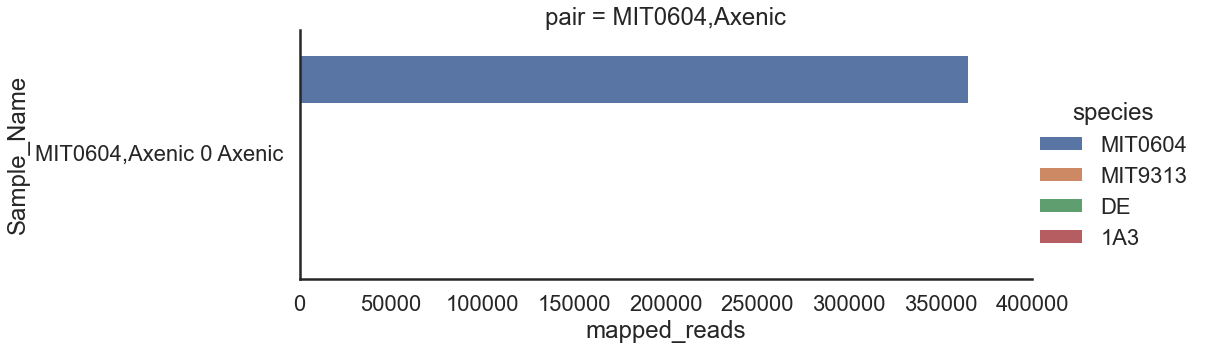

In [33]:
for i in trimmed_df['pair'].dropna().unique():

    g = sns.catplot(data=trimmed_df.loc[(trimmed_df['command'] == 'bamqc') & (trimmed_df['mode'] == 'all')
                                    & (trimmed_df['pair'] == i)
                                   ],
                y='Sample_Name', x='mapped_reads', 
               hue='species', hue_order=['MIT0604', 'MIT9313', 'DE', '1A3'],
                row='pair', sharex=False,
               aspect=3, kind='bar')
#plt.title(i)


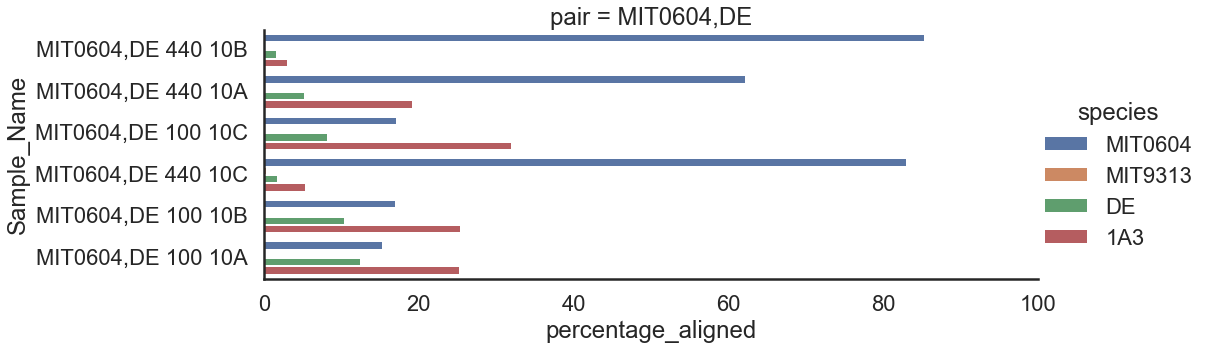

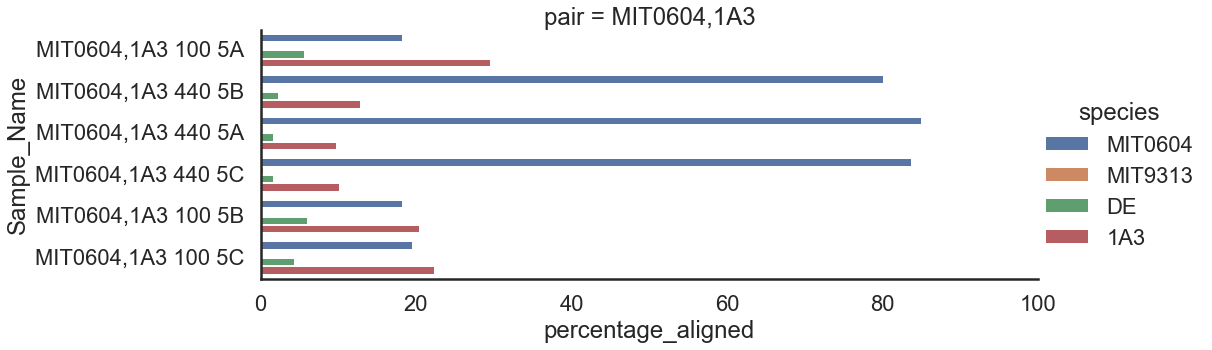

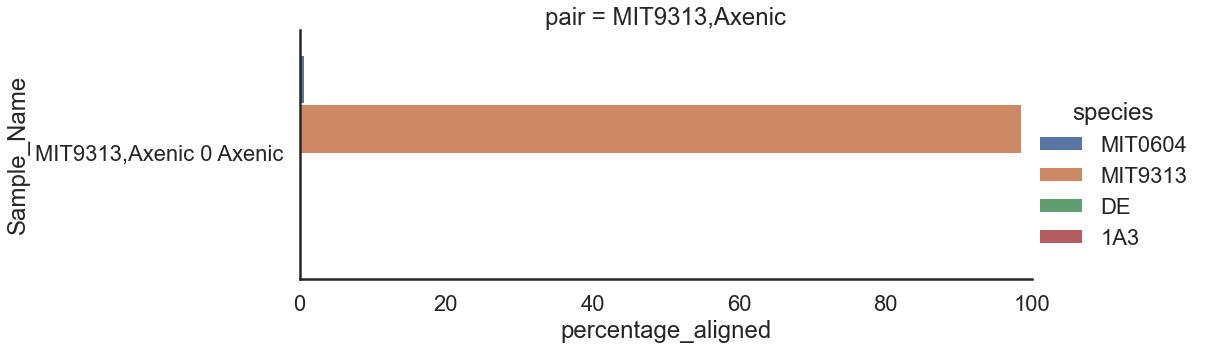

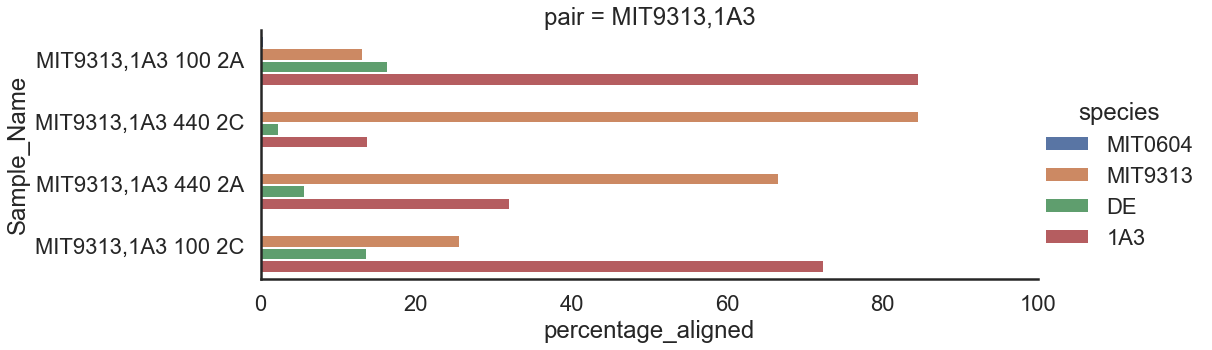

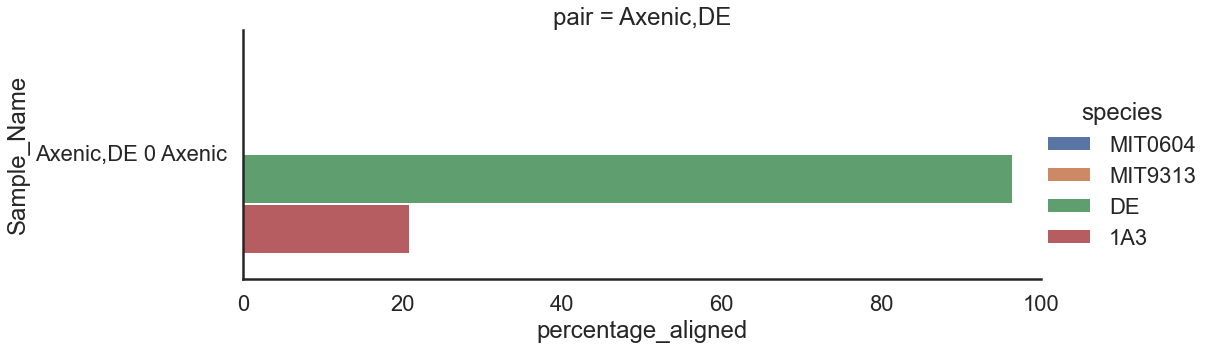

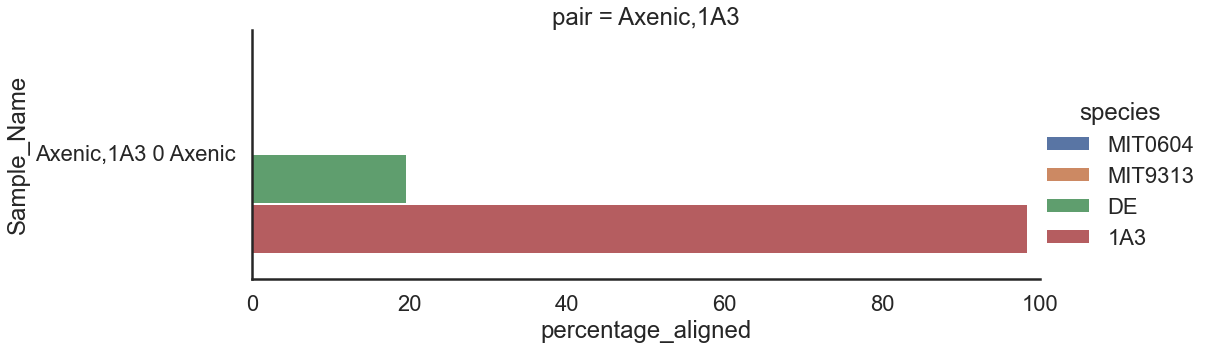

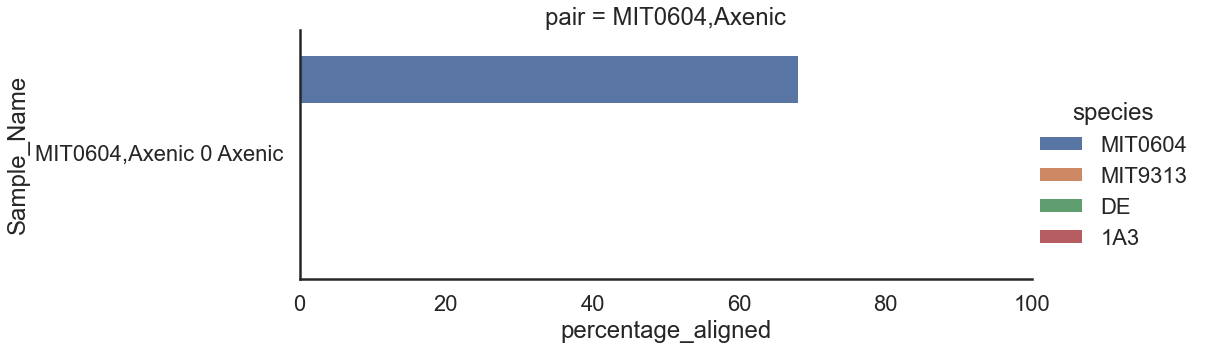

In [34]:
for i in trimmed_df['pair'].dropna().unique():

    g = sns.catplot(data=trimmed_df.loc[(trimmed_df['command'] == 'bamqc') & (trimmed_df['mode'] == 'all')
                                    & (trimmed_df['pair'] == i)
                                   ],
                y='Sample_Name', x='percentage_aligned', 
               hue='species', hue_order=['MIT0604', 'MIT9313', 'DE', '1A3'],
                row='pair', sharex=False,
               aspect=3, kind='bar')
    plt.xlim(0,100)
    plt.show()
#plt.title(i)


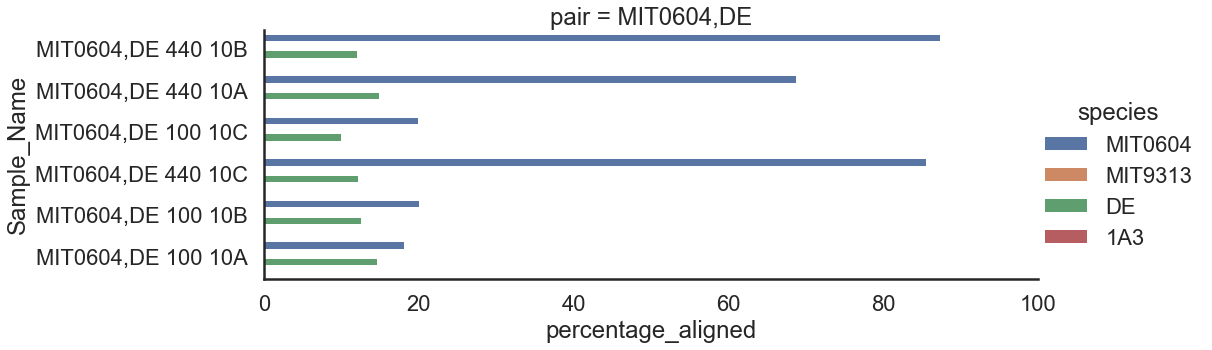

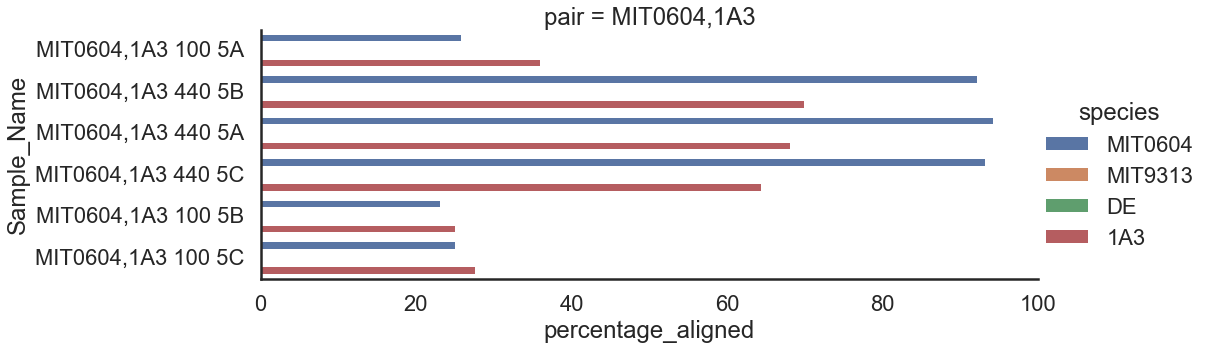

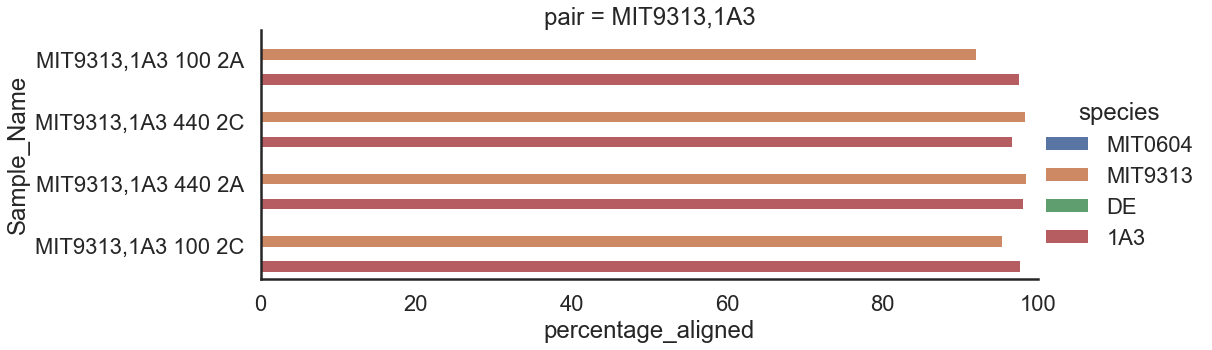

In [35]:
for i in trimmed_df.loc[(trimmed_df['sample'] != 'Axenic'),'pair'].dropna().unique():

    g = sns.catplot(data=trimmed_df.loc[(trimmed_df['command'] == 'bamqc') & (trimmed_df['mode'] == 'filtered')
                                    & (trimmed_df['pair'] == i)
                                   ],
                y='Sample_Name', x='percentage_aligned', 
               hue='species', hue_order=['MIT0604', 'MIT9313', 'DE', '1A3'],
                row='pair', sharex=False,
               aspect=3, kind='bar')
    plt.xlim(0,100)
    plt.show()
#plt.title(i)


In [36]:
trimmed_df.head().T

,0,1,2,3,4
total_reads,488749.0,65170.0,489657.0,489977.0,491414.0
mapped_reads,8101.0,7893.0,15149.0,1455.0,420148.0
percentage_aligned,1.66,12.11,3.09,0.3,85.5
general_error_rate,2.13,2.1,2.02,3.89,0.09
mean_coverage,0.29,0.28,0.5,0.09,38.42
...,...,...,...,...,...
days,440,440,440,440,440
ng/ul,6.25,6.25,6.25,6.25,6.25
final volume,100,100,100,100,100
pair,"MIT0604,DE","MIT0604,DE","MIT0604,DE","MIT0604,DE","MIT0604,DE"


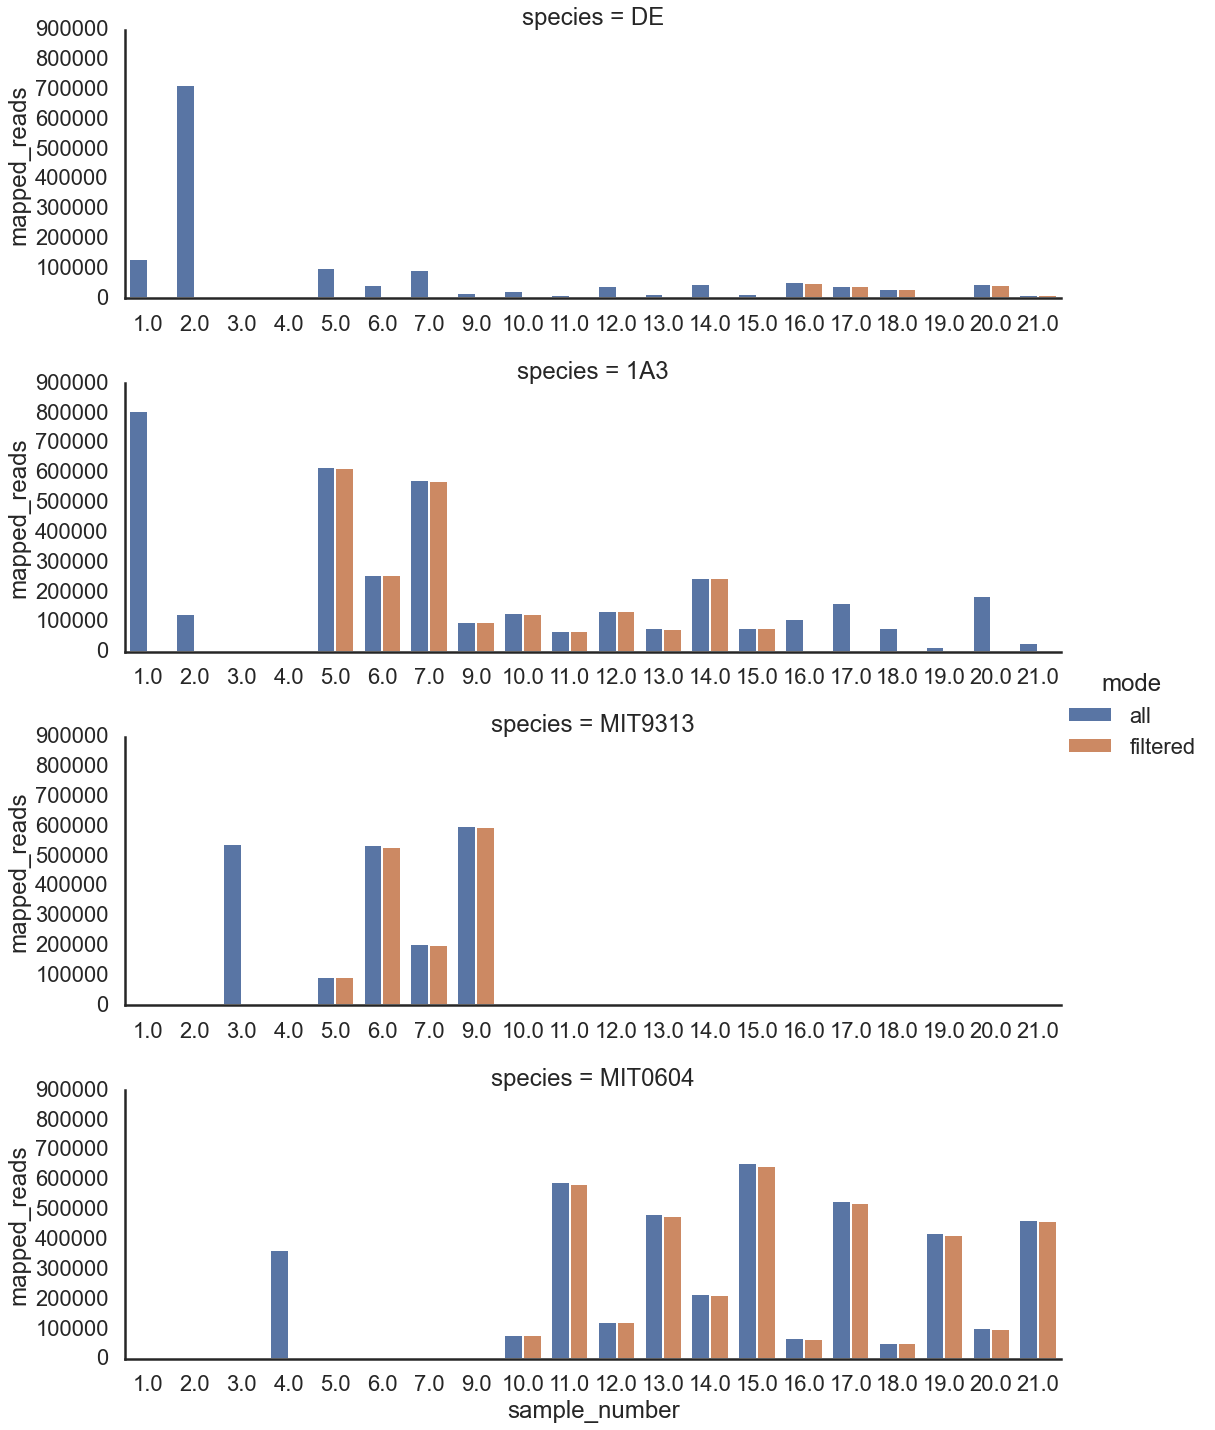

In [37]:
# pd.options.display.float_format = '{:d}'.format
sns.catplot(data=trimmed_df.loc[(trimmed_df['command'] == 'bamqc')],
            x='sample_number', y='mapped_reads', 
           row='species', hue='mode', sharex=False,
           aspect=3, kind='bar')

In [38]:
 trimmed_df.sample_number.dtypes

dtype('float64')

In [39]:
bamqc_df['trim'] = 'adapter'
trimmed_df['trim'] = 'Q>20'
pd.options.display.float_format = '{:.2f}'.format

merged_stat_df = pd.concat([
    bamqc_df.loc[~bamqc_df.species.isin(['Maricaulis '])], 
    trimmed_df.loc[
        (trimmed_df['command'] == 'bamqc') & 
        ((trimmed_df['mode'] == 'filtered') |
         ((trimmed_df['sample_number'] < 5)  & 
          (trimmed_df.PRO == trimmed_df.species) | (trimmed_df.ALT == trimmed_df.species)))
                                            ] 
                                            ],
        )

In [40]:
merged_stat_df.species = merged_stat_df.species.str.strip()

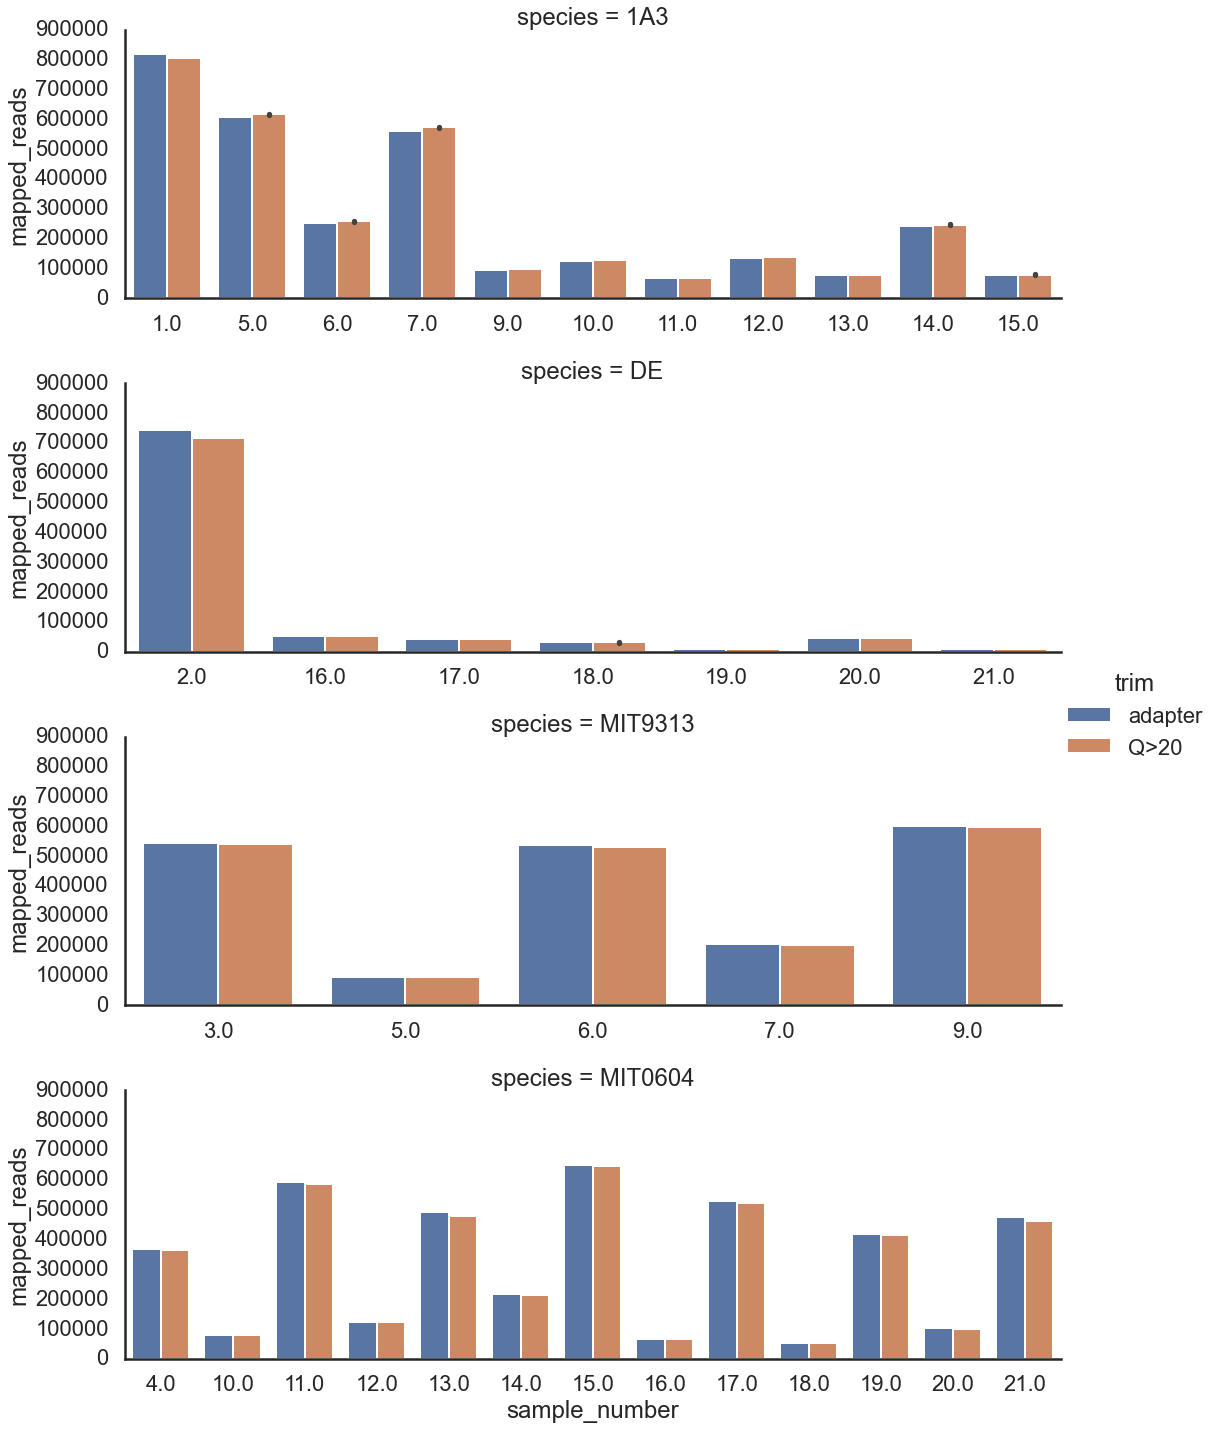

In [41]:
sns.catplot(data=merged_stat_df,
            x='sample_number', y='mapped_reads', 
           row='species', hue='trim', sharex=False,
           aspect=3, kind='bar')

Text(0.5, 1, 'mapped reads')

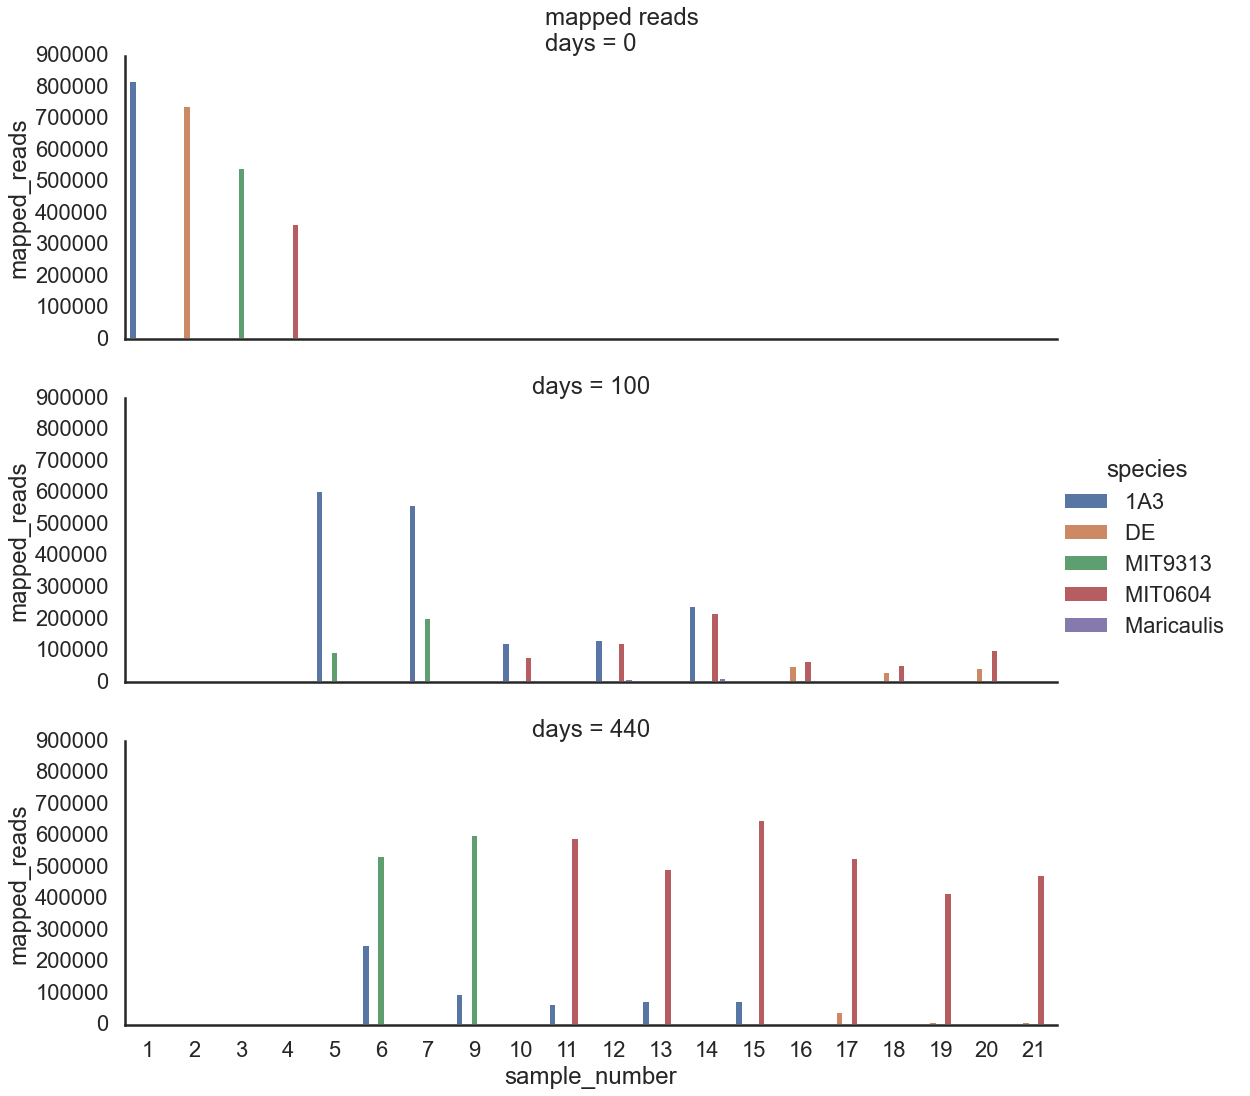

In [42]:
sns.set_style('white')
sns.set_context('poster')
sns.catplot(data=bamqc_df, x='sample_number', y='mapped_reads',hue='species', row='days', 
            kind='bar', aspect=3)
plt.suptitle('mapped reads', y=1)

Text(0.5, 1, '% cov > 10x')

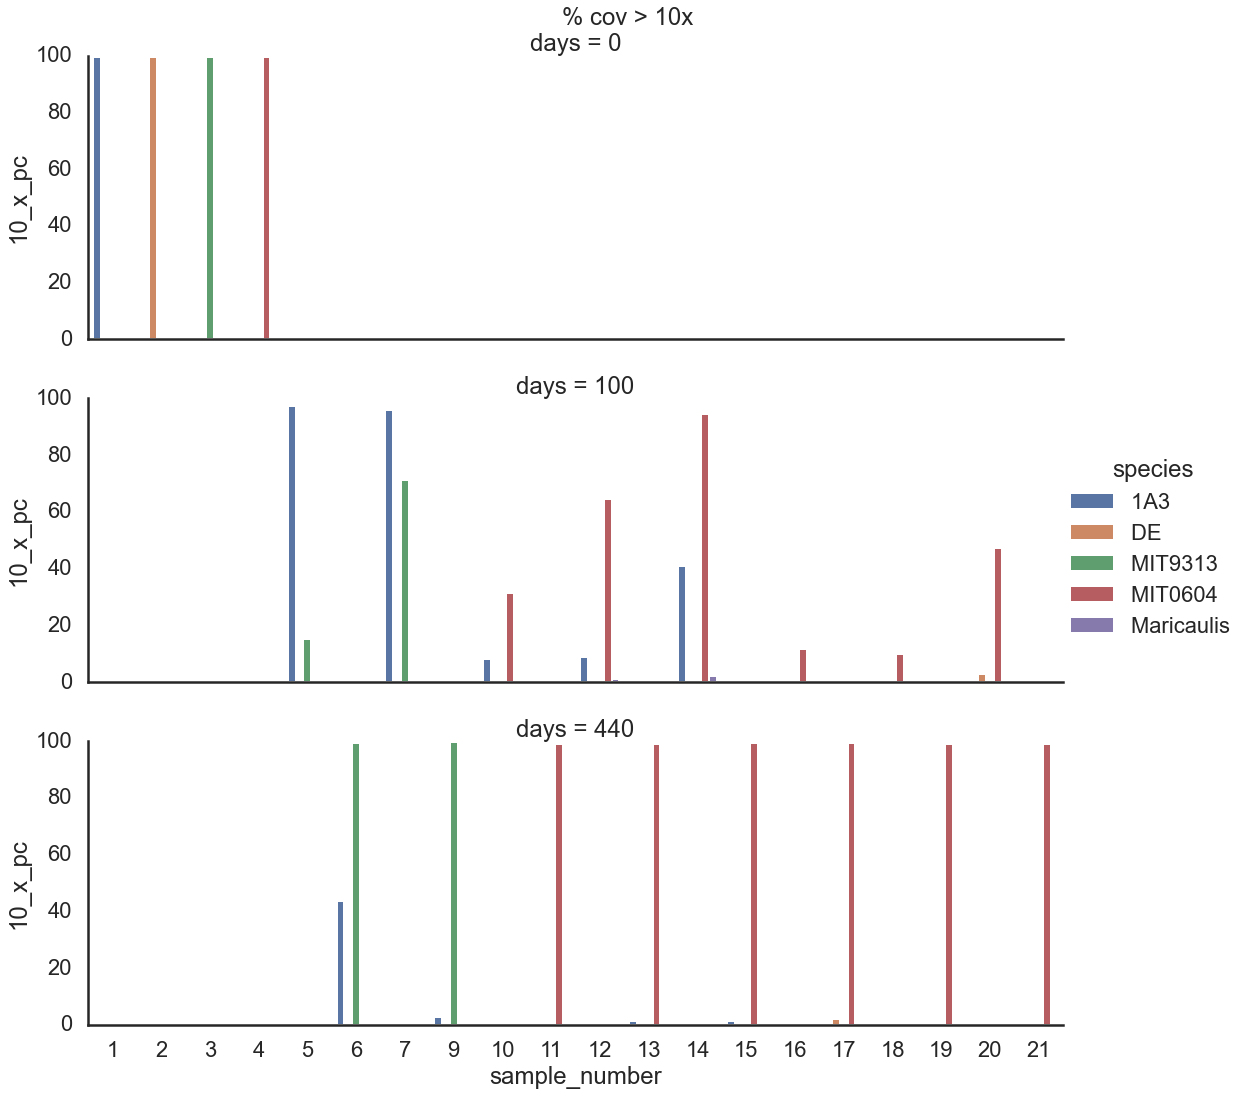

In [43]:
sns.set_style('white')
#sns.set_context('paper')
sns.catplot(data=bamqc_df, x='sample_number', y='10_x_pc',hue='species', row='days', 
            kind='bar', aspect=3)
plt.suptitle('% cov > 10x', y=1)

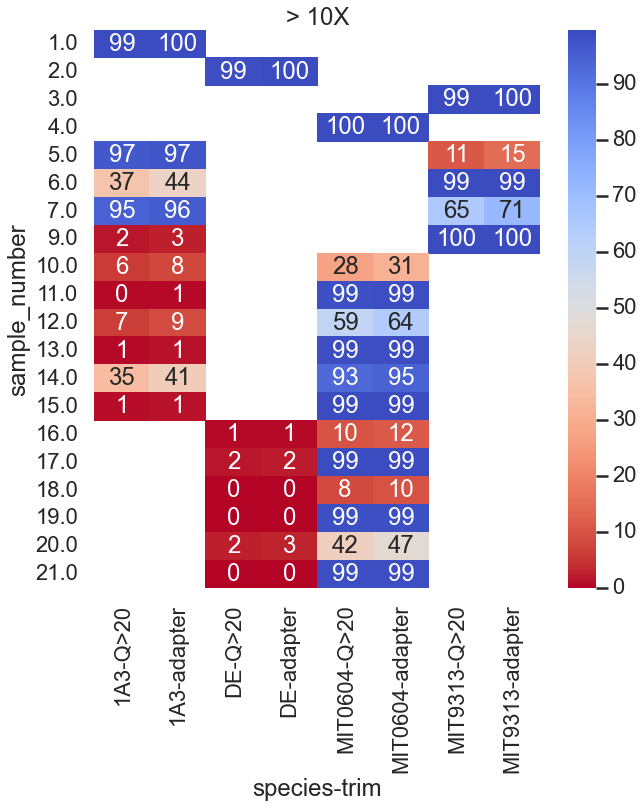

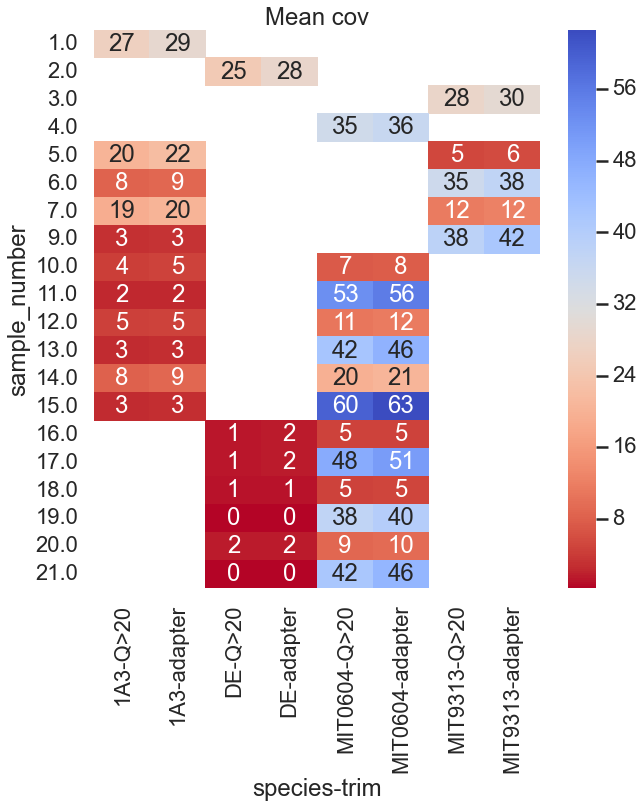

In [44]:
sns.set_context('poster')
value_cols = [  '10_x_pc',
         'mean_coverage',
              #'mapped_reads'
             ]

for v in value_cols:
    # 'sample', 'PRO', 'ALT', 'exp',
    plt.figure(figsize=(10,10))
    
    bamqc_pdf = merged_stat_df.pivot_table(index='sample_number', columns=['species', 'trim'], 
                           values=[v]).droplevel(level=0, axis='columns')
    #bamqc_pdf[pct_cols] = bamqc_pdf[pct_cols]/100
    #bamqc_pdf.rename(columns=qmap_titles, inplace=True)
    sns.heatmap(bamqc_pdf, cmap='coolwarm_r',
                  annot=True, fmt='.0f')
    plt.title(qmap_titles[v])
    plt.show()

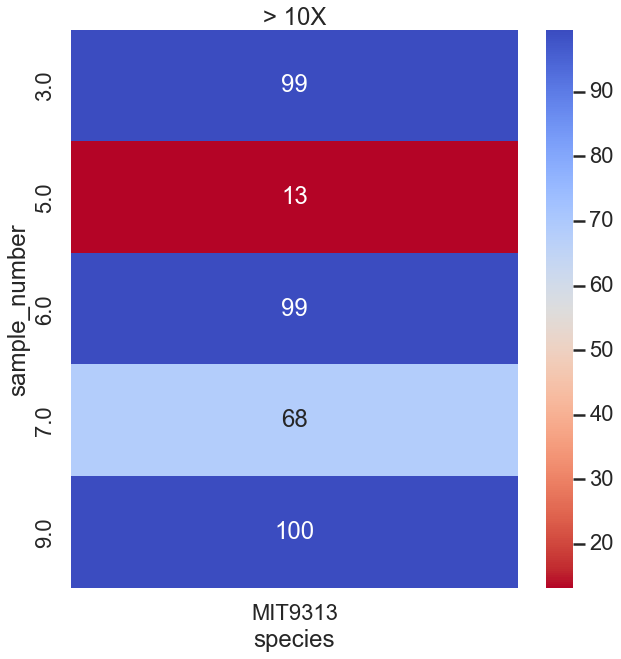

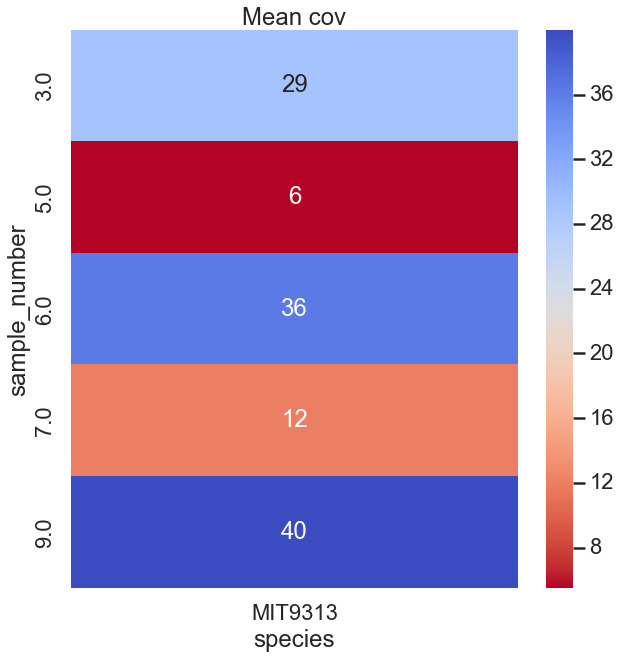

In [45]:
sns.set_context('poster')
value_cols = [  '10_x_pc',
         'mean_coverage',
              #'mapped_reads'
             ]

for v in value_cols:
    # 'sample', 'PRO', 'ALT', 'exp',
    plt.figure(figsize=(10,10))
    
    bamqc_pdf = merged_stat_df.loc[merged_stat_df['species'].isin(['MIT9313'])].pivot_table(index='sample_number', columns=['species'], 
                           values=[v]).droplevel(level=0, axis='columns')
    #bamqc_pdf[pct_cols] = bamqc_pdf[pct_cols]/100
    #bamqc_pdf.rename(columns=qmap_titles, inplace=True)
    sns.heatmap(bamqc_pdf, cmap='coolwarm_r',
                  annot=True, fmt='.0f')
    plt.title(qmap_titles[v])
    plt.show()

In [46]:
merged_stat_df.columns.unique()

Index(['Key', '10_x_pc', '1_x_pc', '30_x_pc', '50_x_pc', '5_x_pc', 'avg_gc',
       'general_error_rate', 'mapped_reads', 'mean_coverage',
       ...
       'dropped_pct', 'percent_gc', 'avg_sequence_length', 'total_sequences',
       'percent_duplicates', 'percent_fails', 'mode', 'command', 'pair',
       'Sample_Name'],
      dtype='object', length=122)

In [47]:
#from glob import glob
#data_dpath = os.path.join('DNA','freebayes')
data_dpath = os.path.join('DNA','dnaseq_trimmed')
# ##INFO=<ID=ANN,Number=.,Type=String,
#Description="Functional annotations: 'Allele | Annotation | Annotation_Impact | 
#            Gene_Name | Gene_ID | Feature_Type | Feature_ID | Transcript_BioType | 
#              Rank | HGVS.c | HGVS.p | 
# cDNA.pos / cDNA.length | CDS.pos / CDS.length | AA.pos / AA.length | Distance | ERRORS / WARNINGS / INFO' ">
def _parse_csv(t):
    ANN_columns = [
        'Allele', 'Annotation',  'Impact', 'Gene_Name', 'Gene_ID', 'Feature_Type',
        'Feature_ID', 'Transcript_BioType', 'Rank', 'HGVS.c', 'HGVS.p', 'cDNA.pos',  'CDS.pos', 
        'AA.pos', 'Distance', 'ERRORS'
    ]
    #idx = 160000+i
    #dname = f'D20-{idx}-4500T'
    #glob(os.path.join(data_dpath, dname,'**', '*.csv'), recursive=True)
    fpath = os.path.join(data_dpath, #f'freebayes_{t}',
                         f'freebayes_{t}.tab')
    df =  pd.read_csv(fpath, sep='\t') 
    df['species'] = t
    df.ANN = df.ANN.str.split(',')
    df = df.apply( pd.Series.explode )


    df[ANN_columns] = df['ANN'].str.split('|', expand=True)
    df = df.drop('ANN', axis=1)
    return df

df_MIT9313 = _parse_csv('MIT9313') 
df_MIT0604 = _parse_csv('MIT0604') 
df_DE = _parse_csv('DE') 
df_1A3 = _parse_csv('1A3') 


In [48]:
def parse_freebayes(genome):
    df_s =  _parse_csv(genome) 
    id_vars=['CHROM', 'POS', 'TYPE', 'REF', 'ALT', 
       'species', 'Allele', 'Annotation', 'Impact', 'Gene_Name', 'Gene_ID',
       'Feature_Type', 'Feature_ID', 'Transcript_BioType', 'Rank', 'HGVS.c',
       'HGVS.p', 'cDNA.pos', 'CDS.pos', 'AA.pos', 'Distance', 'ERRORS']


    d = df_s.melt(id_vars=id_vars)
    d['variable'] = d['variable'].str.replace('D20-1600', '')
    d[['sample_number', 'variable']] = d['variable'].str.split('.',expand=True)
    d['sample_number'] = pd.to_numeric(d['sample_number'])

    pdf = d.pivot_table(index=(id_vars+['sample_number']), columns=['variable'], aggfunc='first', #values='value',
                   ).droplevel(level=0, axis='columns').reset_index() 
    
    pdf['good_call'] = (pdf.DP > 10) & (pdf.GQ > 20)
    mask = (~pdf.AO.astype(str).str.contains(',', na=False, regex=False) & 
            ~pdf.DP.astype(str).str.contains(',', na=False, regex=False) &
            (pdf['DP'] != 0) & pdf['good_call'])
    try: 
        pdf.loc[mask, 'fraction_Alt'] = pdf.loc[mask, 'AO'] / pdf.loc[mask, 'DP']
    except Exception:
        pdf['fraction_Alt'] = ''

    
    pdf['culture'] = 'Co_Culture'
    pdf.loc[pdf['sample_number']<=4, 'culture'] = 'Axenic'
    
    df_genome = pd.read_pickle(os.path.join('DNA', 'genomes',f'{genome}.ncbi.gb.pkl.gz'))
    #df_DE_MIT9313 = pd.read_excel(os.path.join('DNA', 'genomes','41396_2016_BFismej201670_MOESM46_ESM.xlsx'),
    #                          sheet_name='9313+1A3')
    genome_cols = ['gene_id', 'pmt_id', 'type',  'strand', 
       'product', 'protein_id']
    mpdf = pd.merge(pdf, 
                    df_genome[genome_cols], left_on='Gene_Name', right_on='gene_id', 
                    how='left'
                   )
    #mpdf[['PMTID1', 'PMTID2']] = mpdf.pmt_id.str.split(',', expand=True)
    mpdf = pd.merge(mpdf, meta_df, on='sample_number', how='left')
    mpdf['good_call'] = (mpdf.DP > 10) & (mpdf.GQ > 20)
    mpdf.loc[mpdf.good_call & (mpdf.ALT_x == mpdf.GT), 'call'] = 1
    mpdf.loc[mpdf.good_call & (mpdf.REF == mpdf.GT), 'call'] = 0
    mpdf.loc[mpdf.good_call & (mpdf.REF != mpdf.GT) & (mpdf.ALT_x != mpdf.GT), 'call'] = -1
    return mpdf

In [49]:
genome='MIT9313'
df_genome = pd.read_pickle(os.path.join('DNA', 'genomes',f'{genome}.ncbi.gb.pkl.gz'))
df_genome.head()


,contig_id,gene_id,pmt_id,type,location,strand,start,stop,left,right,function,genome,old_locus_tag,product,db_xref,protein_id,figfam,nucleotide_sequence,aa_sequence
0,MIT9313,AKG35_RS00005,"PMT0001,PMT_0001",CDS,AKG35_RS00005,+,173,1340,173,1340,DNA polymerase III subunit beta,MIT9313,"PMT0001,PMT_0001,RG24_RS00005",DNA polymerase III subunit beta,GI:499441916,WP_011129380.1,,,MKLVCSQAELNTALQLVSRAVASRPTHPVLANVLLTADAGTDRLSL...
1,MIT9313,AKG35_RS00010,"PMT0002,PMT_0002",CDS,AKG35_RS00010,+,1343,2120,1343,2120,hypothetical protein,MIT9313,"PMT0002,PMT_0002,RG24_RS00010",hypothetical protein,GI:752737102,WP_041384224.1,,,MNLPDQILLSDLLHHRVRCDQGLDHGPGVLPWMHPPVHRLLGWVSR...
2,MIT9313,AKG35_RS00015,"PMT0003,PMT_0003",CDS,AKG35_RS00015,+,2177,4562,2177,4562,phosphoribosylformylglycinamidine synthase sub...,MIT9313,"PMT0003,PMT_0003,RG24_RS00015",phosphoribosylformylglycinamidine synthase sub...,GI:499441918,WP_011129382.1,,,MRVDYDVAAALRHEGLKPHDYDEICRRLQRAPNRVELGMFGVMWSE...
3,MIT9313,AKG35_RS00020,"PMT0004,PMT_0004",CDS,AKG35_RS00020,+,4621,6079,4621,6079,amidophosphoribosyltransferase,MIT9313,"PMT0004,PMT_0004,RG24_RS00020",amidophosphoribosyltransferase,GI:499441919,WP_011129383.1,,,MCGIVGIVSTALVNQQIYDSLLLLQHRGQDSTGIATMDGSVFHLHK...
4,MIT9313,AKG35_RS00025,"PMT0005,PMT_0005",CDS,AKG35_RS00025,-,6114,8604,6114,8604,DNA topoisomerase 4 subunit A,MIT9313,"PMT0005,PMT_0005,RG24_RS00025",DNA topoisomerase 4 subunit A,GI:499441920,WP_011129384.1,,,MAEERLQPIALHQEMQRSYLEYAMSVIVGRALPDARDGLKPVQRRI...


In [50]:
genome='MIT9313'
df_genome = pd.read_pickle(os.path.join('DNA', 'genomes',f'{genome}.ncbi.gb.pkl.gz'))
df_genome.columns

Index(['contig_id', 'gene_id', 'pmt_id', 'type', 'location', 'strand', 'start',
       'stop', 'left', 'right', 'function', 'genome', 'old_locus_tag',
       'product', 'db_xref', 'protein_id', 'figfam', 'nucleotide_sequence',
       'aa_sequence'],
      dtype='object')

In [51]:
df_genome.loc[df_genome['function'].str.contains('nitrite')]

,contig_id,gene_id,pmt_id,type,location,strand,start,stop,left,right,function,genome,old_locus_tag,product,db_xref,protein_id,figfam,nucleotide_sequence,aa_sequence
2423,MIT9313,AKG35_RS11935,"PMT2239,PMT_2239",CDS,AKG35_RS11935,+,2365138,2366767,2365138,2366767,ferredoxin--nitrite reductase,MIT9313,"PMT2239,PMT_2239,RG24_RS11960",ferredoxin--nitrite reductase,GI:499444139,WP_011131603.1,,,MVISSPAKQFLQGKKLNKIEQNKAFKDGLDVGDELENFAQLGWEQV...
2425,MIT9313,AKG35_RS11945,"PMT2240,PMT_2240",CDS,AKG35_RS11945,+,2367030,2367921,2367030,2367921,formate/nitrite transporter family protein,MIT9313,"PMT2240,PMT_2240,RG24_RS11970",formate/nitrite transporter family protein,GI:499444140,WP_011131604.1,,,MDYVLPNELVDGMITAGGKKSSVSIKNLLVRGFYSGAILGLATCLA...


In [52]:
dfs = dict()
for s in ['MIT0604', 'MIT9313', 'DE', '1A3']:
    dfs[s] = parse_freebayes(s)


In [53]:
df_DE_MIT9313 = pd.read_excel(os.path.join('DNA', 'genomes','41396_2016_BFismej201670_MOESM46_ESM.xlsx'),
                              sheet_name='9313+1A3')
df_DE_MIT9313.rename(columns={'log 2 fold change coculture/axenic' : 'log Fold Change'}, inplace=True)
de_cols = ['Synonym', 'q Value ', 'log Fold Change']
dfs['MIT9313'][['PMTID1', 'PMTID2']] = dfs['MIT9313'].pmt_id.str.split(',', expand=True)

dfs['MIT9313'] = pd.merge(dfs['MIT9313'], 
                df_DE_MIT9313[de_cols], left_on='PMTID1', right_on='Synonym', 
                how='left'
               )


In [54]:
all_cols = ['CHROM', 'POS', 'TYPE', 'REF', 'ALT_x', 'species', 'Allele',
       'Annotation', 'Impact', 'Gene_Name', 'Gene_ID', 'Feature_Type',
       'Feature_ID', 'Transcript_BioType', 'Rank', 'HGVS.c', 'HGVS.p',
       'cDNA.pos', 'CDS.pos', 'AA.pos', 'Distance', 'ERRORS', 'sample_number',
       'AO', 'DP', 'RO', 'fraction_Alt', 'culture', 'gene_id', 'pmt_id',
       'type', 'strand', 'product', 'pmt_id', 'PMTID2', 'Synonym', 'q Value ',
       'log Fold Change', 'sample', 'PRO', 'ALT_y', 'exp',
       'days', 'ng/ul', 'final volume']
 

index_cols = ['CHROM', 'POS', 'TYPE', 'REF', 'ALT_x', 'Annotation', 'Impact',
              'HGVS.p', 'HGVS.c', 'CDS.pos', 'AA.pos',
              'gene_id', 'pmt_id', 'type', 'strand', 'product']
additional_index_cols = ['q Value ', 'log Fold Change',]

column_cols = ['PRO', 'ALT_y', 'days','sample', ]
value_cols = ['call', 'fraction_Alt', 'DP', 'AO', 'RO','GQ','GT',  ]
species= 'MIT9313'


condition_format_cols = {
    'MIT9313' : ['T7:X10000', 'Y7:AC10000' ],
    'MIT0604' : ['R7:AD10000', 'AE7:AQ10000' ],
    '1A3' : ['R7:AB10000', 'AC7:AM10000' ],
    'DE' : ['R7:X20000', 'Y7:AE10000' ],
    
}  
fraction_cols = {
    'MIT9313' :  'Y:AC',
    'MIT0604' :  'AE:AQ',
    '1A3' : 'AC:AM' ,
    'DE' :  'Y:AE' ,
    
}  


#agg_f = lambda x : ' | '.join(x.unique())
with pd.ExcelWriter('var_calls_5x5_MIT9313.xlsx', engine='xlsxwriter') as writer:  
    workbook  = writer.book
    format1 = workbook.add_format({'num_format': '#,##0.00'})
    format2 = workbook.add_format({'num_format': '0%'})
    for species, col in zip(['MIT9313', 'MIT0604', '1A3', 'DE'], ['PRO', 'PRO', 'ALT_y', 'ALT_y']):
        actual_index_cols = index_cols
        if species == 'MIT9313':
            actual_index_cols = index_cols + additional_index_cols
        excel_pdf = dfs[species].loc[dfs[species]['type'].isin(['CDS'])].fillna('').pivot_table(
            index=actual_index_cols, columns=column_cols,
            aggfunc='first', margins=False, values=value_cols,
            fill_value='',
        ).reindex(columns=value_cols, level=0,
        ).reindex(columns=['Axenic', '1A3', 'DE'], level='ALT_y',
        ).reindex(columns=['Axenic', 'MIT9313', 'MIT0604'], level='PRO',).reset_index()
        excel_pdf = excel_pdf.loc[excel_pdf['call'].replace('',np.NaN).std(axis=1) != 0]
        sheetname = f'{species} calls'
        excel_pdf.to_excel(writer, sheet_name=sheetname)
        worksheet = writer.sheets[sheetname]
        worksheet.set_column(fraction_cols[species], None, format1)
        if species == 'MIT9313':
            worksheet.set_column('R:S', None, format1)
        worksheet.set_column('Q:Q', 30)  # Col 1 has format1.
        worksheet.set_column('G:G', 12)  # Col 1 has format1.
                
        worksheet.conditional_format(condition_format_cols[species][0], 
                                     {'type': '2_color_scale',                               
                                      'min_color': '#b7efcd', 
                                    #  'mid_color': 'yellow', 
                                      'max_color': '#ffbcbc'
                                     })
        worksheet.conditional_format(condition_format_cols[species][1],  
                                     {'type': '2_color_scale',                               
                                      'min_color': 'white', 
                                    #  'mid_color': 'yellow', 
                                      'max_color': '#f69e7b'
                                     })
        #worksheet.conditional_format(f'K1:L{bamqc_df.shape[0]+2}', {'type': 'data_bar', 'bar_color' : 'green'})


In [55]:
dfs[species].columns

Index(['CHROM', 'POS', 'TYPE', 'REF', 'ALT_x', 'species', 'Allele',
       'Annotation', 'Impact', 'Gene_Name', 'Gene_ID', 'Feature_Type',
       'Feature_ID', 'Transcript_BioType', 'Rank', 'HGVS.c', 'HGVS.p',
       'cDNA.pos', 'CDS.pos', 'AA.pos', 'Distance', 'ERRORS', 'sample_number',
       'AO', 'DP', 'GQ', 'GT', 'RO', 'good_call', 'fraction_Alt', 'culture',
       'gene_id', 'pmt_id', 'type', 'strand', 'product', 'protein_id',
       'sample', 'PRO', 'ALT_y', 'exp', 'days', 'ng/ul', 'final volume',
       'call'],
      dtype='object')

Text(0.5, 1.0, 'MIT9313 calls')

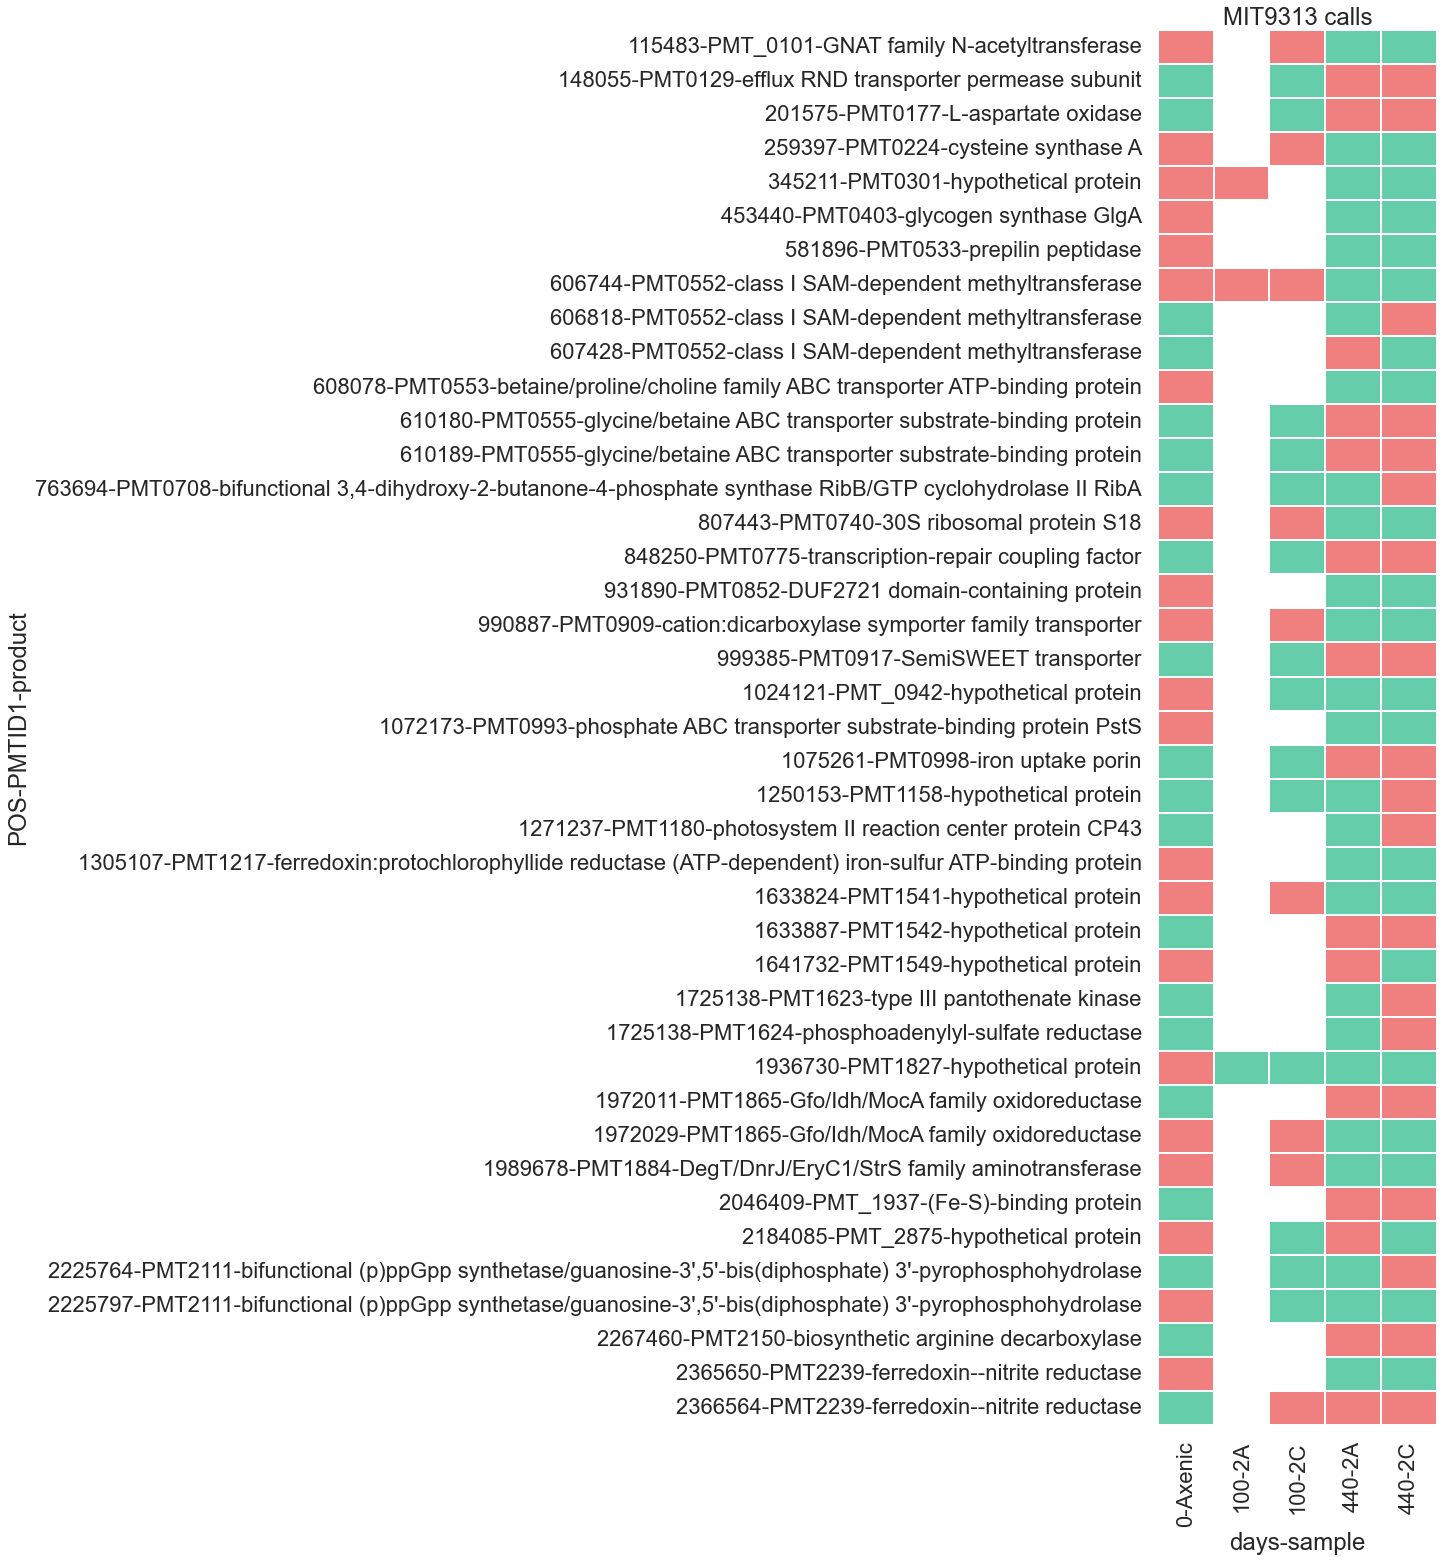

In [56]:
species = 'MIT9313'
plt.figure(figsize=(5,25))
pvdf = dfs[species].loc[dfs[species].type == 'CDS'].pivot_table(index=['POS', 'PMTID1', 'product',], 
                                                columns=[ 'days','sample',], values='call', aggfunc='first')
sns.heatmap(pvdf.loc[pvdf.std(axis=1) > 1e-1], #.sort_values((  0, 'Axenic')),
            cmap=['MediumAquamarine', 'lightcoral'],
            linewidths=1, linecolor='white', cbar=False)
plt.title(f'{species} calls')

In [57]:
species = 'MIT9313'
pvdf = dfs[species].pivot_table(index=['POS','type', 'TYPE'], 
                                                columns=[ 'days','sample',], values='call', aggfunc='first')
pvdf = pvdf.reset_index()
pvdf.loc[pvdf.std(axis=1) > 1e-1]
good_call_gene_ids = pvdf.loc[pvdf.iloc[:, pvdf.columns.get_level_values(0)!='POS'].std(axis=1) > 1e-1, 'POS']

dfs[species]['diff_snp'] = False
dfs[species].loc[dfs[species]['POS'].isin(good_call_gene_ids), 'diff_snp'] = True



In [58]:
dfs[species]['diff_snp'].value_counts()

True     756
False    738
Name: diff_snp, dtype: int64

In [59]:
dfs[species].head()

,CHROM,POS,TYPE,REF,ALT_x,species,Allele,Annotation,Impact,Gene_Name,...,days,ng/ul,final volume,call,PMTID1,PMTID2,Synonym,q Value,log Fold Change,diff_snp
0,NC_005071,66297,INDEL,GC,G,MIT9313,G,frameshift_variant,HIGH,AKG35_RS00340,...,0,0.6,100,1.00,PMT0064,PMT_0064,PMT0064,0.75,-0.76,False
1,NC_005071,66297,INDEL,GC,G,MIT9313,G,frameshift_variant,HIGH,AKG35_RS00340,...,100,0.7,100,NaN,PMT0064,PMT_0064,PMT0064,0.75,-0.76,False
2,NC_005071,66297,INDEL,GC,G,MIT9313,G,frameshift_variant,HIGH,AKG35_RS00340,...,440,1.2,100,1.00,PMT0064,PMT_0064,PMT0064,0.75,-0.76,False
3,NC_005071,66297,INDEL,GC,G,MIT9313,G,frameshift_variant,HIGH,AKG35_RS00340,...,100,1.5,100,NaN,PMT0064,PMT_0064,PMT0064,0.75,-0.76,False
4,NC_005071,66297,INDEL,GC,G,MIT9313,G,frameshift_variant,HIGH,AKG35_RS00340,...,empty,empty,empty,NaN,PMT0064,PMT_0064,PMT0064,0.75,-0.76,False


Text(0.5, 1.0, 'MIT0604 calls')

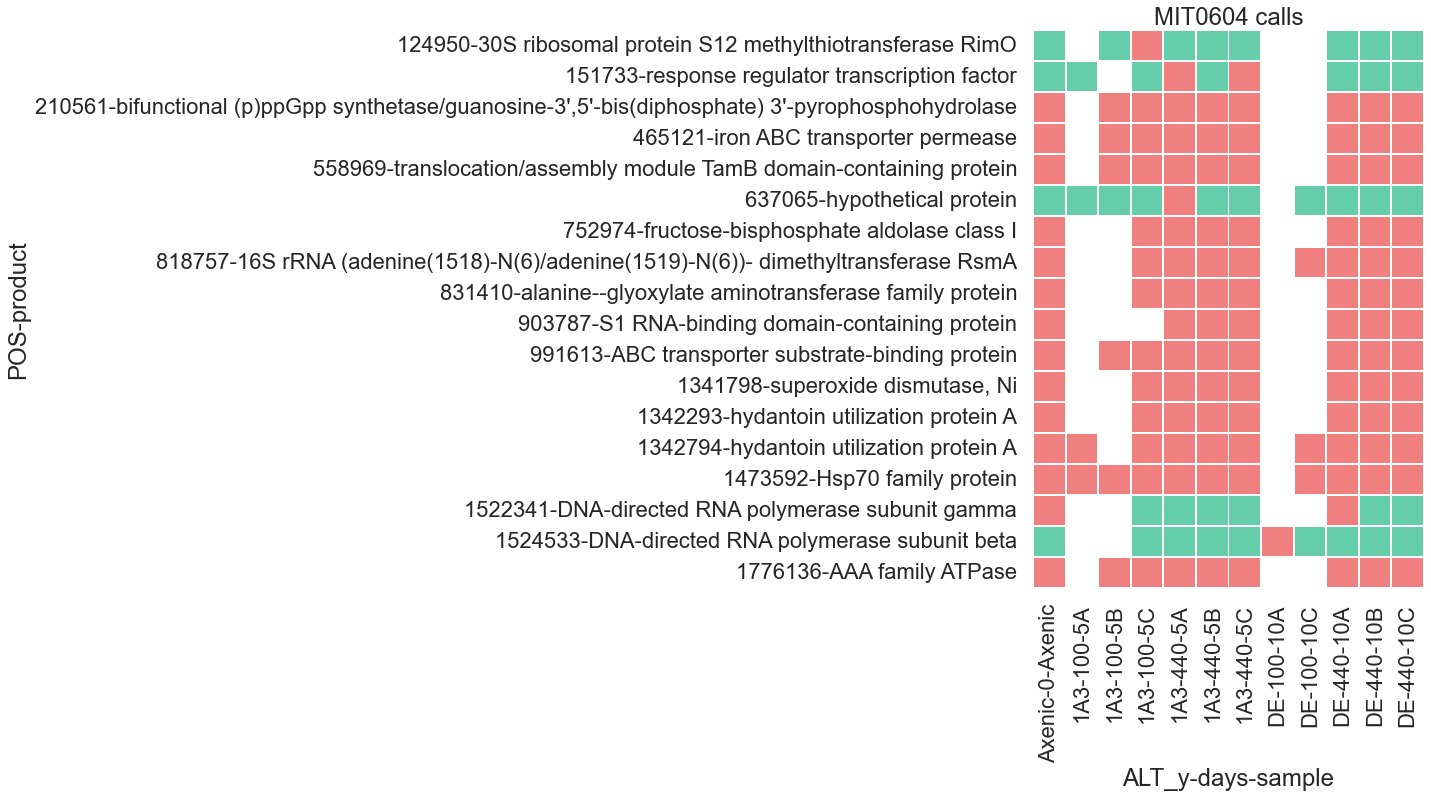

In [60]:
species = 'MIT0604'
plt.figure(figsize=(7,10))
pvdf = dfs[species].loc[dfs[species].type == 'CDS'].pivot_table(index=[ 'POS', 'product',], 
                                                columns=[ 'ALT_y', 'days','sample'], 
                                                                values='call', aggfunc='first')
pvdf = pvdf.reindex(columns=['Axenic', '1A3', 'DE'], level='ALT_y',)
sns.heatmap(pvdf, #.loc[pvdf.std(axis=1) > 1e-1], #.sort_values(( 0, 'Axenic','Axenic', )),
            cmap=['MediumAquamarine', 'lightcoral'],
            linewidths=1, linecolor='white', cbar=False)
plt.title(f'{species} calls')

Text(0.5, 1.0, 'MIT0604 calls')

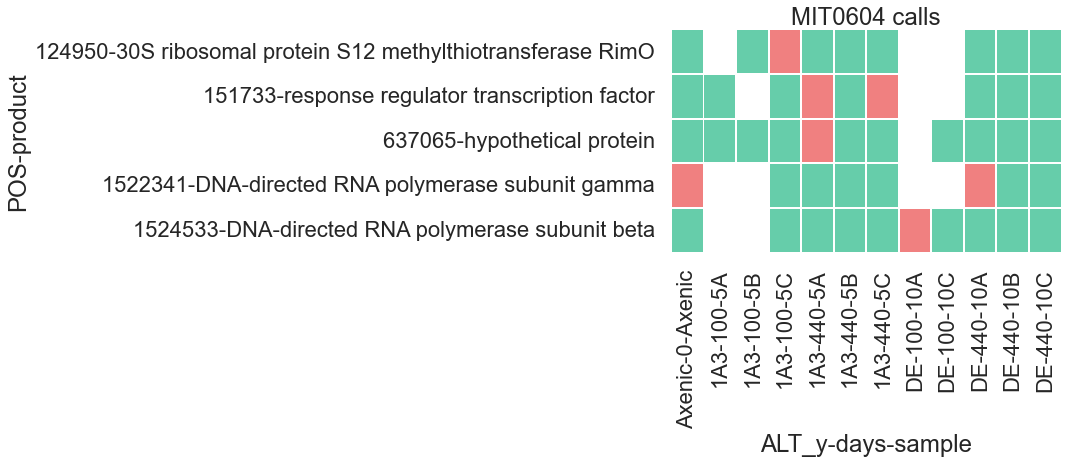

In [61]:
species = 'MIT0604'
plt.figure(figsize=(7,4))
pvdf = dfs[species].loc[dfs[species].type == 'CDS'].pivot_table(index=[ 'POS','product',], 
                                                columns=[ 'ALT_y', 'days','sample'], 
                                                                values='call', aggfunc='first')
pvdf = pvdf.reindex(columns=['Axenic', '1A3', 'DE'], level='ALT_y',)
sns.heatmap(pvdf.loc[pvdf.std(axis=1) > 1e-1], #.sort_values(( 0, 'Axenic','Axenic', )),
            cmap=['MediumAquamarine', 'lightcoral'],
            linewidths=1, linecolor='white', cbar=False)
plt.title(f'{species} calls')

In [62]:
species = 'MIT9313'
dfs[species].loc[(dfs[species].type == 'CDS') & (dfs[species].good_call)].Gene_Name.nunique()

67

Text(0.5, 1.0, 'Fraction of Alternate Allele')

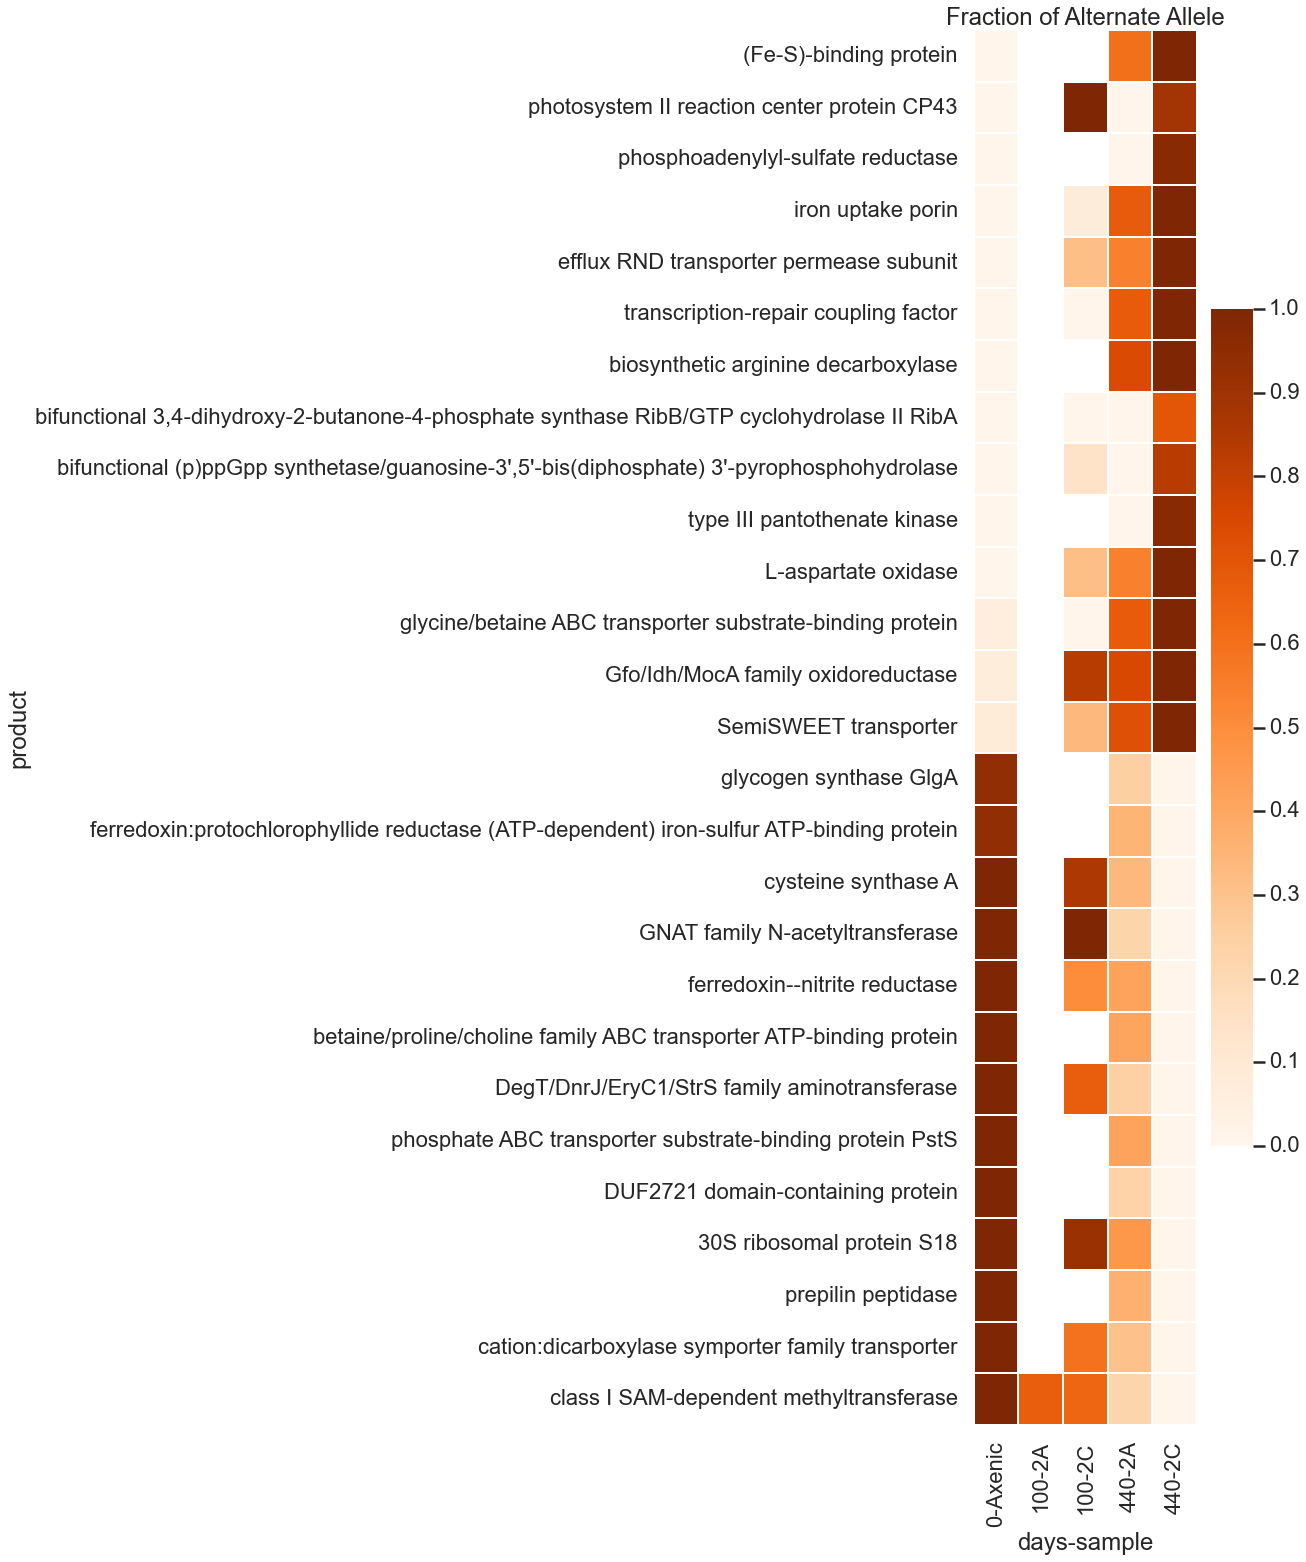

In [63]:
species = 'MIT9313'
plt.figure(figsize=(5,25))
pvdf = dfs[species].loc[(dfs[species].type == 'CDS') & (dfs[species].good_call)
               ].pivot_table(index=['product',], # 'POS', 'PMTID1','product',], 
                                                columns=[ 'days','sample',], values='fraction_Alt', aggfunc='first')
#pvdf.index = [f'{col[0]} : {col[1]} - {col[2]}' for col in pvdf.index.values]
sns.heatmap(pvdf.loc[pvdf.std(axis=1) > 1e-1].sort_values((  0, 'Axenic')),
            cmap='Oranges',
            linewidths=1, linecolor='white', #cbar=False
           )
plt.title('Fraction of Alternate Allele')

In [64]:
# colors
GLY_COLOR = '#a2ff1e'
PPGPP_COLOR = '#1efffa'
NIRA_COLOR = '#ff1eeb'
colors_gene_highlight = {
# glycine/betaine
'AKG35_RS02910': GLY_COLOR,
'AKG35_RS02915' : GLY_COLOR,
'AKG35_RS02925' : GLY_COLOR,

# ppGpp
'AKG35_RS11235' : PPGPP_COLOR,

# nira
'AKG35_RS11935' : NIRA_COLOR,
}
sns.color_palette([GLY_COLOR, PPGPP_COLOR, NIRA_COLOR])

[(0.6352941176470588, 1.0, 0.11764705882352941),
 (0.11764705882352941, 1.0, 0.9803921568627451),
 (1.0, 0.11764705882352941, 0.9215686274509803)]

Text(0.5, 1.0, 'Fraction of Alternate Allele')

<Figure size 360x1800 with 0 Axes>

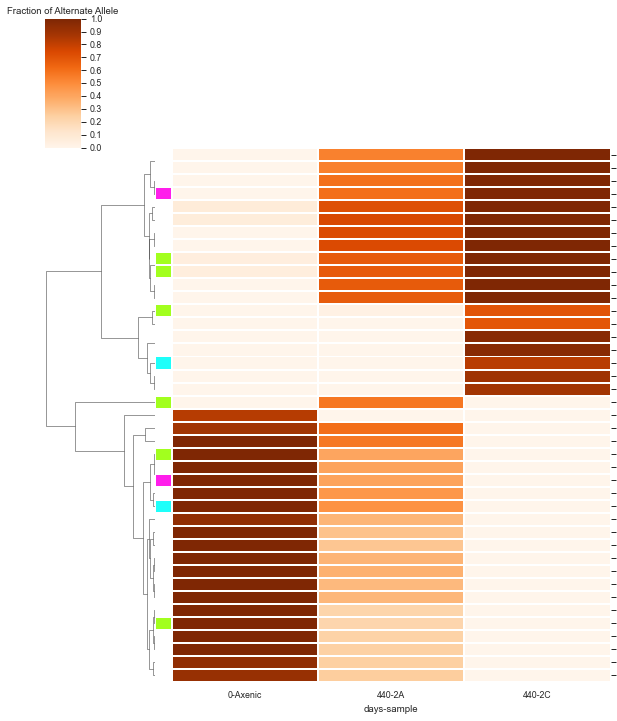

In [65]:
sns.set_context('paper')
species = 'MIT9313'
plt.figure(figsize=(5,25))

#lut = dict(zip(species.unique(), "rbg"))

#row_colors = species.map(lut)

pvdf = dfs[species].loc[(dfs[species].type == 'CDS') & (dfs[species].diff_snp) 
                        & (dfs[species].days != 100)
               ].pivot_table(index=['POS', 'gene_id',], # 'POS', 'PMTID1','product',], 
                                                columns=[ 'days','sample',], values='fraction_Alt', aggfunc='first')

row_colors = pvdf.index.get_level_values(1).map(colors_gene_highlight).fillna('white')
#pvdf.index = [f'{col[0]} : {col[1]} - {col[2]}' for col in pvdf.index.values]
g = sns.clustermap(pvdf, # .loc[pvdf.std(axis=1) > 1e-1],
            cmap='Oranges',
            linewidths=1, linecolor='white', #cbar=False
               #figsize=(5,15),
                   vmin=0, vmax=1, col_cluster=False,
               row_colors=row_colors
           )
g.ax_heatmap.set_yticklabels([])
g.ax_heatmap.set_ylabel('')
plt.title('Fraction of Alternate Allele')

Text(0.5, 1.0, 'Fraction of Alternate Allele')

<Figure size 360x1800 with 0 Axes>

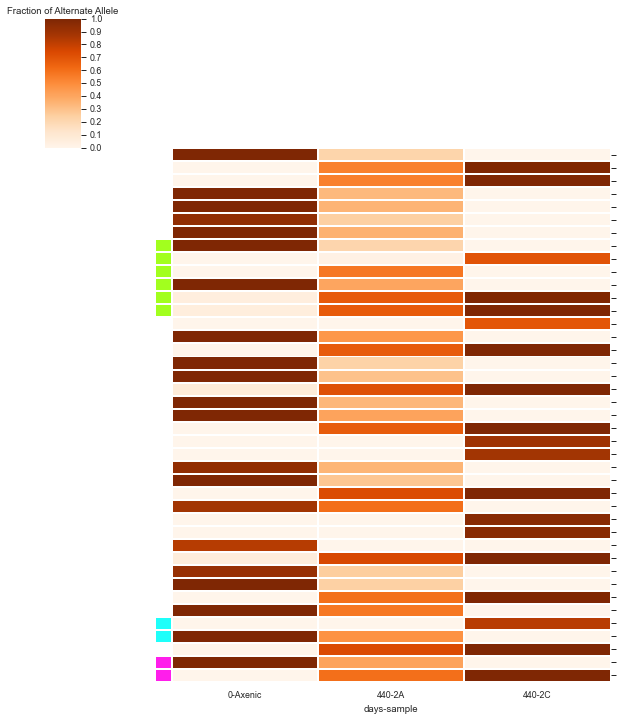

In [66]:
sns.set_context('paper')
species = 'MIT9313'
plt.figure(figsize=(5,25))

#lut = dict(zip(species.unique(), "rbg"))

#row_colors = species.map(lut)

pvdf = dfs[species].loc[(dfs[species].type == 'CDS') & (dfs[species].diff_snp) 
                        & (dfs[species].days != 100)
               ].pivot_table(index=['POS', 'gene_id',], # 'POS', 'PMTID1','product',], 
                                                columns=[ 'days','sample',], values='fraction_Alt', aggfunc='first')

row_colors = pvdf.index.get_level_values(1).map(colors_gene_highlight).fillna('white')
#pvdf.index = [f'{col[0]} : {col[1]} - {col[2]}' for col in pvdf.index.values]
g = sns.clustermap(pvdf, # .loc[pvdf.std(axis=1) > 1e-1],
            cmap='Oranges',
            linewidths=1, linecolor='white', #cbar=False
               #figsize=(5,15),
                   vmin=0, vmax=1, col_cluster=False,row_cluster=False,
               row_colors=row_colors
           )
g.ax_heatmap.set_yticklabels([])
g.ax_heatmap.set_ylabel('')
plt.title('Fraction of Alternate Allele')

Text(0.5, 1.0, 'Fraction of Alternate Allele')

<Figure size 360x1800 with 0 Axes>

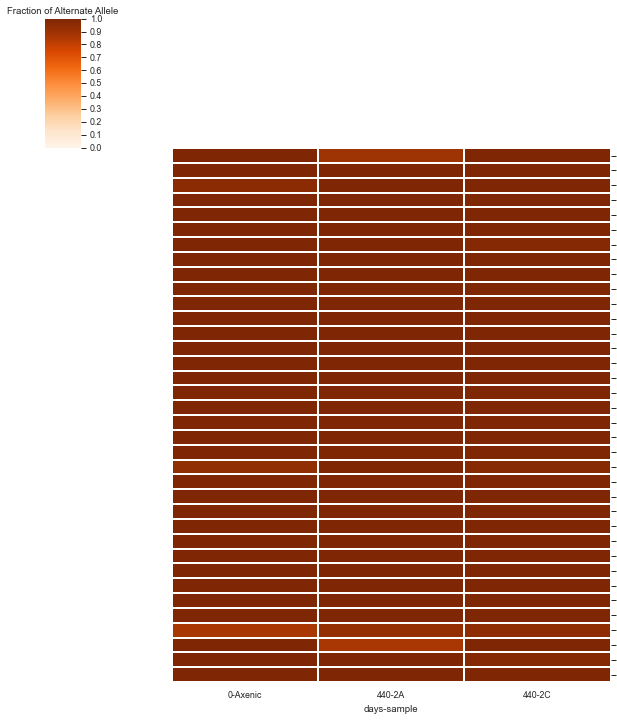

In [67]:
sns.set_context('paper')
species = 'MIT9313'
plt.figure(figsize=(5,25))

#lut = dict(zip(species.unique(), "rbg"))

#row_colors = species.map(lut)

pvdf = dfs[species].loc[(dfs[species].type == 'CDS') & (~dfs[species].diff_snp) 
                        & (dfs[species].days != 100)
               ].pivot_table(index=['POS', 'gene_id',], # 'POS', 'PMTID1','product',], 
                                                columns=[ 'days','sample',], values='fraction_Alt', aggfunc='first')

row_colors = pvdf.index.get_level_values(1).map(colors_gene_highlight).fillna('white')
#pvdf.index = [f'{col[0]} : {col[1]} - {col[2]}' for col in pvdf.index.values]
g = sns.clustermap(pvdf, # .loc[pvdf.std(axis=1) > 1e-1],
            cmap='Oranges',
            linewidths=1, linecolor='white', #cbar=False
               #figsize=(5,15),
                   vmin=0, vmax=1, col_cluster=False,row_cluster=False,
               row_colors=row_colors
           )
g.ax_heatmap.set_yticklabels([])
g.ax_heatmap.set_ylabel('')
plt.title('Fraction of Alternate Allele')

Text(0.5, 1.0, 'MIT0604: fraction of Alternate Allele')

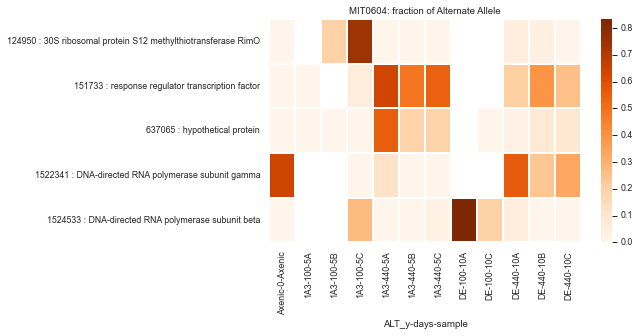

In [68]:
species = 'MIT0604'
plt.figure(figsize=(7,4))
pvdf = dfs[species].loc[(dfs[species].type == 'CDS') & (dfs[species].good_call)
               ].pivot_table(index=[ 'POS', 'product',], 
                                                columns=[ 'ALT_y', 'days','sample',], values='fraction_Alt', aggfunc='first')
pvdf = pvdf.reindex(columns=['Axenic', '1A3', 'DE'], level='ALT_y',)
pvdf.index = [f'{col[0]} : {col[1]}' for col in pvdf.index.values]
sns.heatmap(pvdf.loc[pvdf.std(axis=1) > 1e-1], #.sort_values((  0, 'Axenic')),
            cmap='Oranges',
            linewidths=1, linecolor='white', #cbar=False
           )
plt.title(f'{species}: fraction of Alternate Allele')

Text(0.5, 1.0, 'MIT0604: fraction of Alternate Allele')

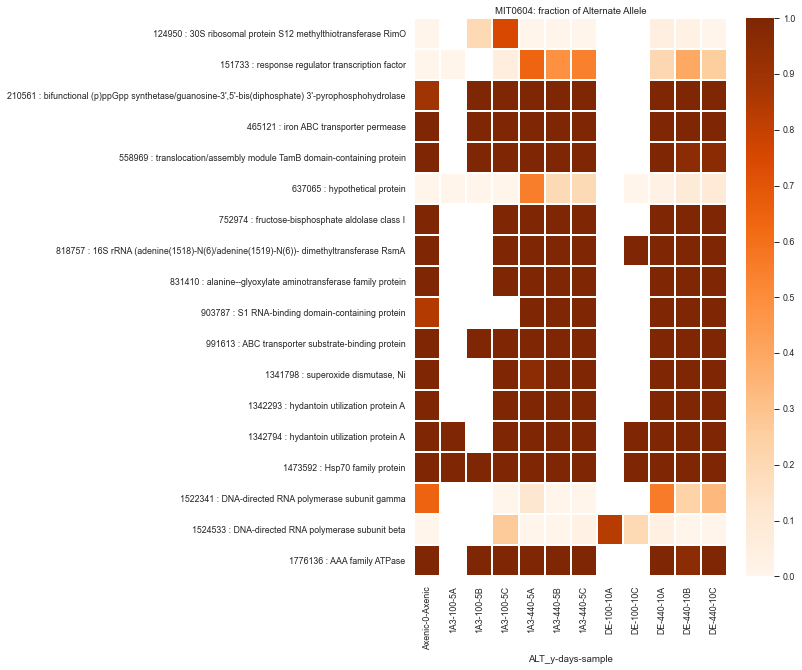

In [69]:
species = 'MIT0604'
plt.figure(figsize=(7,10))
pvdf = dfs[species].loc[(dfs[species].type == 'CDS') & 
                         dfs[species].good_call & 
                        (dfs[species].PRO == species)
               ].pivot_table(index=[ 'POS', 'product',], 
                             columns=[ 'ALT_y', 'days','sample',], 
                             values='fraction_Alt', aggfunc='first', #dropna=False
                            )
pvdf = pvdf.reindex(columns=['Axenic', '1A3', 'DE'], level='ALT_y',)
pvdf.index = [f'{col[0]} : {col[1]}' for col in pvdf.index.values]
sns.heatmap(pvdf, #.loc[pvdf.std(axis=1) > 1e-1], #.sort_values((  0, 'Axenic')),
            cmap='Oranges',
            linewidths=1, linecolor='white', #cbar=False
           )
plt.title(f'{species}: fraction of Alternate Allele')

In [70]:
pvdf.shape

(18, 12)

In [71]:
species = 'MIT9313'
dfs[species].loc[(dfs[species].type == 'CDS') & 
                         dfs[species].good_call & 
                        (dfs[species].PRO == species) &
                        #(dfs[species].call == 1) &
                        (dfs[species].days != 100)

 ].pivot_table(index=[ 'Impact','Annotation'], 
                              columns=['sample',], 
                              values='call', aggfunc='sum', margins=True, #dropna=False
                             )
#pivot_table(['sample',  'Impact','Annotation', ])['TYPE'].count().reset_index()

sample                         2A    2C  Axenic    All
Impact   Annotation                                   
HIGH     frameshift_variant  8.00  8.00   10.00  26.00
         stop_gained         1.00  1.00    2.00   4.00
         stop_lost           1.00  1.00    1.00   3.00
LOW      synonymous_variant  6.00  5.00    8.00  19.00
MODERATE missense_variant   35.00 40.00   36.00 111.00
All                         51.00 55.00   57.00 163.00

In [72]:
species = 'MIT9313'
mdf = dfs[species].loc[(dfs[species].type == 'CDS') & 
                         dfs[species].good_call & 
                        (dfs[species].PRO == species) &
                        #(dfs[species].call == 1) &
                        (dfs[species].days != 100)
               ].pivot_table(index=[ 'POS', 'Impact','Annotation'], 
                             columns=[ 'sample',], 
                             values='call', aggfunc='first', #dropna=False
                            ).reset_index()
mdf.head()

# ].pivot_table(index=[ 'Impact','Annotation'], 
#                              columns=['sample',], 
#                              values='fraction_Alt', aggfunc='count', #dropna=False
#                             )
#pivot_table(['sample',  'Impact','Annotation', ])['TYPE'].count().reset_index()

sample,POS,Impact,Annotation,2A,2C,Axenic
0,66297,HIGH,frameshift_variant,1.00,1.00,1.00
1,99578,HIGH,stop_gained,1.00,1.00,1.00
2,115483,MODERATE,missense_variant,0.00,0.00,1.00
3,148055,MODERATE,missense_variant,1.00,1.00,0.00
4,201575,MODERATE,missense_variant,1.00,1.00,0.00


In [73]:
    display(
        mdf.pivot_table(index=[ 'Axenic', '2A', '2C'], 
                             columns=[ 'Impact','Annotation',], 
                             values='POS', aggfunc='count',
                        margins=True, #dropna=False
                            ).reset_index().fillna(0)
    )


Impact     Axenic  2A  2C               HIGH                        \
Annotation                frameshift_variant stop_gained stop_lost   
0             0.0 0.0 1.0               0.00        0.00      0.00   
1             0.0 1.0 0.0               0.00        0.00      0.00   
2             0.0 1.0 1.0               0.00        0.00      0.00   
3             1.0 0.0 0.0               2.00        1.00      0.00   
4             1.0 1.0 0.0               0.00        0.00      0.00   
5             1.0 1.0 1.0               8.00        1.00      1.00   
6             All                      10.00        2.00      1.00   

Impact                    LOW         MODERATE All  
Annotation synonymous_variant missense_variant      
0                        0.00             6.00   6  
1                        0.00             1.00   1  
2                        1.00            11.00  12  
3                        3.00            13.00  19  
4                        1.00             1.00   2  
5                        4.00            22.00  36  
6                        9.00            54.00  76

In [74]:
for s in ['2A', '2C']:
    display(
        mdf.pivot_table(index=[ 'Axenic', s], 
                             columns=[ 'Impact','Annotation',], 
                             values='POS', aggfunc='count',
                        margins=True, #dropna=False
                            ).reset_index().fillna(0)
    )


Impact     Axenic  2A               HIGH                        \
Annotation            frameshift_variant stop_gained stop_lost   
0             0.0 0.0               0.00        0.00      0.00   
1             0.0 1.0               0.00        0.00      0.00   
2             1.0 0.0               2.00        1.00      0.00   
3             1.0 1.0               8.00        1.00      1.00   
4             All                  10.00        2.00      1.00   

Impact                    LOW         MODERATE All  
Annotation synonymous_variant missense_variant      
0                        0.00             6.00   6  
1                        1.00            12.00  13  
2                        3.00            13.00  19  
3                        5.00            23.00  38  
4                        9.00            54.00  76

Impact     Axenic  2C               HIGH                        \
Annotation            frameshift_variant stop_gained stop_lost   
0             0.0 0.0               0.00        0.00      0.00   
1             0.0 1.0               0.00        0.00      0.00   
2             1.0 0.0               2.00        1.00      0.00   
3             1.0 1.0               8.00        1.00      1.00   
4             All                  10.00        2.00      1.00   

Impact                    LOW         MODERATE All  
Annotation synonymous_variant missense_variant      
0                        0.00             1.00   1  
1                        1.00            17.00  18  
2                        4.00            14.00  21  
3                        4.00            22.00  36  
4                        9.00            54.00  76

In [75]:
mdf.groupby(['Axenic', '2A', '2C']).count().reset_index()

sample,Axenic,2A,2C,POS,Impact,Annotation
0,0.00,0.00,1.00,6,6,6
1,0.00,1.00,0.00,1,1,1
2,0.00,1.00,1.00,12,12,12
3,1.00,0.00,0.00,19,19,19
4,1.00,1.00,0.00,2,2,2
5,1.00,1.00,1.00,36,36,36


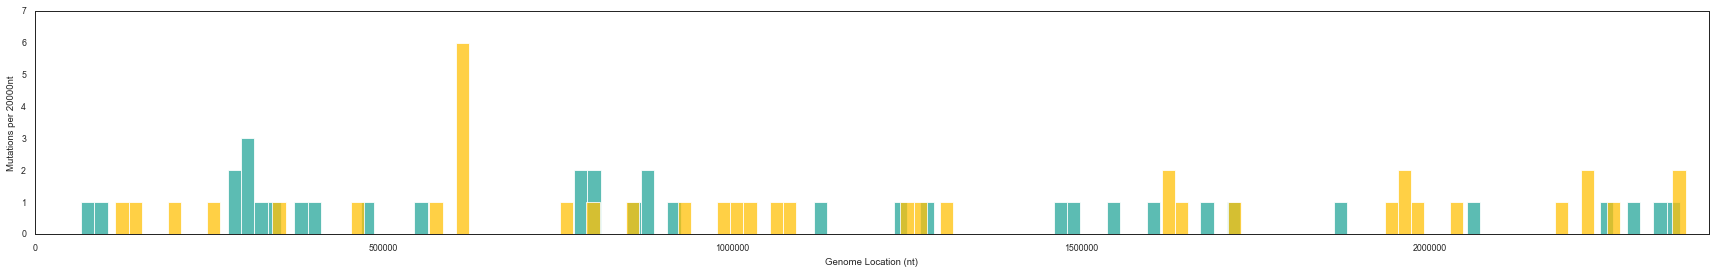

In [76]:
species = 'MIT9313'
t = dfs[species]
t = t.loc[t.type.isin(['CDS'])].groupby(['POS', 'TYPE', 'diff_snp'])['call'].first().reset_index()
t1= t.loc[~t.diff_snp]
t2= t.loc[t.diff_snp]
plt.figure(figsize=(30,4))


sns.histplot(t1['POS'], kde=False, bins=120, #hist_kws=dict(alpha=0.3), #rug=True,
             color='#26A69A', label='unchanged mutations')
sns.histplot(t2['POS'], kde=False, bins=120, #hist_kws=dict(alpha=0.5), #rug=True,
             color='#FFC107', #rug_kws=dict(height=1/3), 
             label='New Mutations')

#sns.rugplot(t.POS, height=0.1)
#sns.rugplot(t2.POS, height=0.5, color='Orange')
#sns.scatterplot(x=t2.POS, y=7/3, s=400, color='#FFA000', alpha=0.25,#hue=t2.Annotation, 
                #markeredgecolor ='r',#palette='range', hue=1
                #markerfacecolors='none'
#               )
glicine_region = (605826, 610831)
#plt.plot(glicine_region[0],10, glicine_region[1],10, marker='o',color='green' )
plt.ylim(0,7)
plt.xlabel('Genome Location (nt)')
plt.ylabel('Mutations per 20000nt')
plt.xlim(0,2.4e6)
#plt.yticks([])
plt.show()


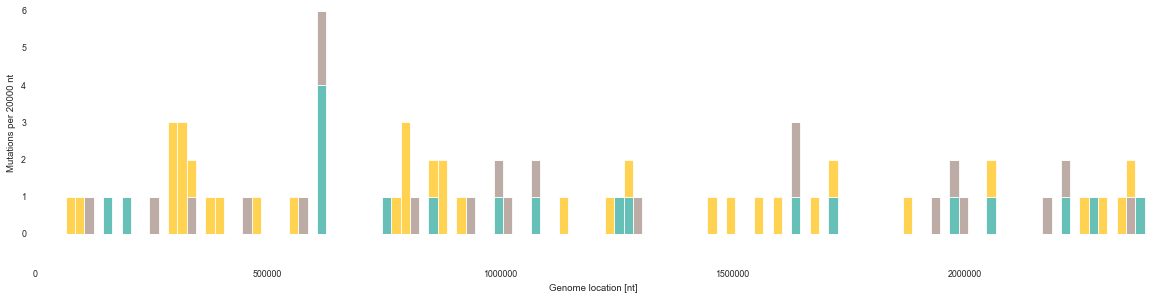

(0.0, 2400000.0)

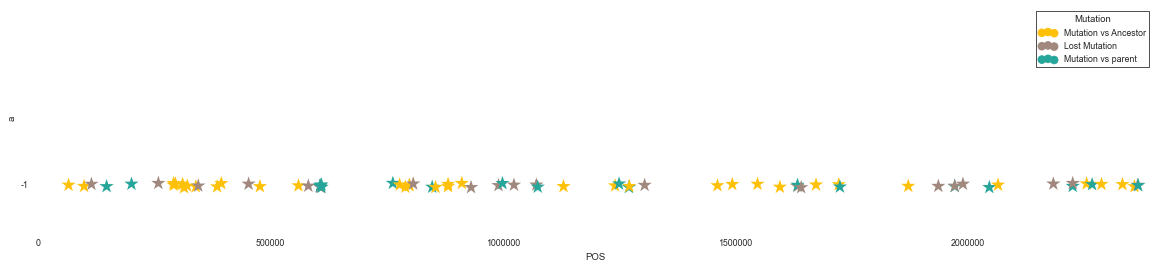

In [77]:
species = 'MIT9313'
t = dfs[species]
t = t.loc[t.type.isin(['CDS'])].groupby(['POS', 'TYPE', 'diff_snp', 'days'])['call'].first().reset_index()
t = t.loc[t.days == 0]

t.loc[~t.diff_snp, 'Mutation'] = 'Mutation vs Ancestor'
t.loc[t.diff_snp & (t.call == 0), 'Mutation'] = 'Mutation vs parent'
t.loc[t.diff_snp & (t.call == 1), 'Mutation'] = 'Lost Mutation'
t['a'] = '-1'
plt.figure(figsize=(20,4))
ax = sns.histplot(data=t,  hue='Mutation', x='POS',binwidth=20000, #aspect=3, #kind='strip',
            #height=3, 
                multiple='stack',
                 # element='step',
            #order=['New Mutation','Removed Mutation', 'Existing Mutation',], 
            palette=[ '#FFC107', '#A1887F', '#26A69A',],
            #s=200, marker="*", 
            #edgecolor="gray", #
                  legend=False,
                 alpha=.7
           )
sns.despine(left=True, bottom=True)
plt.xlim(0,2.4e6)
plt.xlabel('Genome location [nt]')
plt.ylabel('Mutations per 20000 nt')

ax.tick_params(axis='x', pad=30)
plt.show()
plt.figure(figsize=(20,4))
sns.stripplot(data=t, y='a', hue='Mutation', x='POS', #aspect=5, #kind='strip',
            #height=3, 
            #order=['New Mutation','Removed Mutation', 'Existing Mutation',], 
            palette=[ '#FFC107', '#A1887F', '#26A69A',],
            s=15, marker="*", 
         #   ax =ax,
            #edgecolor="gray", #alpha=.5
           )
sns.despine(left=True, bottom=True)
#
plt.ylim(-2, 8)
#plt.ytics((0,1,2,3,4,5,6,7))
plt.xlim(0,2.4e6)

In [78]:
import urllib.parse
import urllib.request
import io

import requests, sys
# go terms for all mit9313 genes
url = 'https://www.uniprot.org/uniprot/'
columns =  ['id','entry name','protein names','genes','organism','length',
            'go(biological process)','go(cellular component)',
    'go(molecular function)']

params = {
    'query' : 'taxonomy:74547',
    'format' : 'tab',
    'columns' : ','.join(columns),
    'compress' : 'no',
}

data = urllib.parse.urlencode(params)
data = data.encode('utf-8')
req = urllib.request.Request(url, data)
with urllib.request.urlopen(req) as f:
   response = f.read()
mit9313_go_df1 = pd.read_csv(io.StringIO(response.decode('utf-8')), sep='\t')



In [79]:
mit9313_go_df1.shape

(2834, 9)

In [80]:
mmit9313_go_df1 = mit9313_go_df1.melt(
    id_vars=['Entry', 'Entry name', 'Protein names', 'Gene names', 'Organism', 'Length'],
    value_name='GO term',
    var_name='GO aspect',
).dropna(subset=['GO term'],axis=0).reset_index(drop=True)

In [81]:
s = mmit9313_go_df1['GO term'].str.split('; ', expand=True).stack()
i = s.index.get_level_values(0)
df3 = mmit9313_go_df1.loc[i].copy()
df3["GO term"] = s.values
df3[["GO term", 'GOid']] = df3["GO term"].str.split(r' \[G', expand=True)
df3['GOid'] = df3['GOid'].str.replace(']', '')
df3['GOid'] = df3['GOid'].str.replace('O:', 'GO:')

C:\Users\Osnat\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  


In [82]:
all_go_df = df3

In [83]:
species = 'MIT9313'
pvdf = dfs[species].loc[dfs[species].type == 'CDS'].pivot_table(index=['protein_id', 'gene_id', 'product'], 
                                                columns=[ 'days','sample',], values='call', aggfunc='first')
pvdf = pvdf.reset_index()
pvdf['actual_snp'] = pvdf.std(axis=1) > 1e-1


In [84]:
dfs[species].POS.value_counts()
#dfs[species].head().T
#dfs[species].columns
dfs[species].loc[dfs[species].POS==685346     ]

,CHROM,POS,TYPE,REF,ALT_x,species,Allele,Annotation,Impact,Gene_Name,...,days,ng/ul,final volume,call,PMTID1,PMTID2,Synonym,q Value,log Fold Change,diff_snp
510,NC_005071,685346,SNP,N,G,MIT9313,G,intragenic_variant,MODIFIER,AKG35_RS00225,...,0,0.6,100,1.00,PMT_RNA_44,None,NaN,NaN,NaN,False
511,NC_005071,685346,SNP,N,G,MIT9313,G,intragenic_variant,MODIFIER,AKG35_RS00225,...,100,0.7,100,NaN,PMT_RNA_44,None,NaN,NaN,NaN,False
512,NC_005071,685346,SNP,N,G,MIT9313,G,intragenic_variant,MODIFIER,AKG35_RS00225,...,440,1.2,100,1.00,PMT_RNA_44,None,NaN,NaN,NaN,False
513,NC_005071,685346,SNP,N,G,MIT9313,G,intragenic_variant,MODIFIER,AKG35_RS00225,...,100,1.5,100,1.00,PMT_RNA_44,None,NaN,NaN,NaN,False
514,NC_005071,685346,SNP,N,G,MIT9313,G,intragenic_variant,MODIFIER,AKG35_RS00225,...,empty,empty,empty,NaN,PMT_RNA_44,None,NaN,NaN,NaN,False
515,NC_005071,685346,SNP,N,G,MIT9313,G,intragenic_variant,MODIFIER,AKG35_RS00225,...,440,8,100,1.00,PMT_RNA_44,None,NaN,NaN,NaN,False
516,NC_005071,685346,SNP,N,G,MIT9313,G,intragenic_variant,MODIFIER,AKG35_RS00225,...,0,0.6,100,1.00,PMT_RNA_44,None,NaN,NaN,NaN,False
517,NC_005071,685346,SNP,N,G,MIT9313,G,intragenic_variant,MODIFIER,AKG35_RS00225,...,100,0.7,100,NaN,PMT_RNA_44,None,NaN,NaN,NaN,False
518,NC_005071,685346,SNP,N,G,MIT9313,G,intragenic_variant,MODIFIER,AKG35_RS00225,...,440,1.2,100,1.00,PMT_RNA_44,None,NaN,NaN,NaN,False
519,NC_005071,685346,SNP,N,G,MIT9313,G,intragenic_variant,MODIFIER,AKG35_RS00225,...,100,1.5,100,1.00,PMT_RNA_44,None,NaN,NaN,NaN,False


In [178]:
# --ming: #16697aff;
# --pacific-blue: #489fb5ff;
# --middle-blue: #82c0ccff;
# --isabelline: #ede7e3ff;
# --orange-peel: #ffa62bff;

# palette
color_list = [
'#16697aff',
 '#489fb5ff',
 '#82c0ccff',
 '#ede7e3ff',
 '#ffa62bff',
    '#f9c188', '#f9cc88', #'#f9d288', 
    '#f9e388', #'#f9e988'
]
## '#f9c188', '#f9cc88', '#f9d288', '#f9e388', '#f9e988'


muorder = ['Evolved', 'Reference']
muorder2 = ['Evolved', 'Reference', 'silent']

mupalette = [
   # '#451E3D', '#BC64A9',
    '#4e386e','#8d71b4',
             #'grey',
              '#c9bcbd',

            ]

sns.color_palette(color_list)

muiorder = ['ReferenceHIGH', 'ReferenceMODERATE', 'ReferenceLOW','ReferenceMODIFIER',
            'EvolvedHIGH', 'EvolvedMODERATE','EvolvedLOW','EvolvedMODIFIER']
       

muipalette = [
    # reference
    '#162830',
    '#437a92',
'#16697aff',
 '#489fb5ff',
 '#82c0ccff',
 '#ede7e3ff',
    # evolved
    '#C13100',
 '#ffa62bff',
    '#f9c188', '#f9cc88', 
    '#f9d288', 
    '#f9e388', 
    '#f9e988',
    '#ffe989',
     '#fff4e3',
    '#ffe8c5',
 '#ede7e3ff',    
]
sns.color_palette(mupalette)


[(0.3058823529411765, 0.2196078431372549, 0.43137254901960786),
 (0.5529411764705883, 0.44313725490196076, 0.7058823529411765),
 (0.788235294117647, 0.7372549019607844, 0.7411764705882353)]

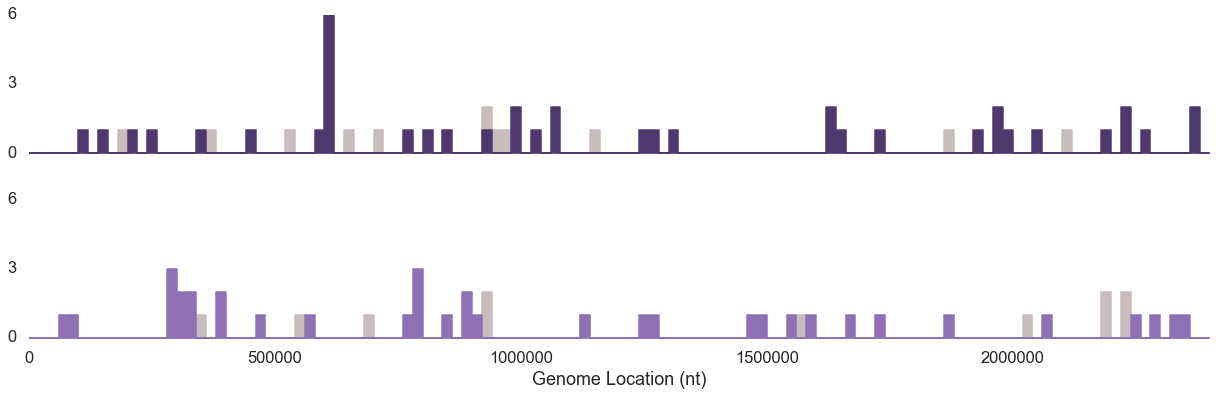

In [184]:
sns.set_context('talk')
species = 'MIT9313'
t = dfs[species]
t = t.groupby(['POS', 'TYPE', 'diff_snp', 'Impact'])['call'].first().reset_index()

t['Mutation_type'] = 'Reference'
t.loc[t.diff_snp, 'Mutation_type'] = 'Evolved'
t = t.sort_values(by='Impact', key=lambda x: x.map({'HIGH': 0, 'MODERATE': 1, 'LOW': 2, 'MODIFIER': 3 }))
t = t.drop_duplicates(subset='POS')
t['type_impact'] = t['Mutation_type'] 
t.loc[t.Impact.isin(['MODIFIER']),'type_impact'] = 'silent'

sns.displot(data = t, x='POS', kde=False, bins=120, #bins=240, 
            row='Mutation_type',
            #facet_kws=dict(row_order=muorder),
            row_order=muorder,
            hue='type_impact',
            hue_order=muorder2,
            palette=mupalette,
            aspect=6,
            height=3,
            legend=False,
            binrange=(0,2.4e6),
            common_bins=True,
            element='step',
            #multiple='stack',
            #{“layer”, “dodge”, “stack”, “fill”}
            alpha=1,
            fill=True,
            ).set_titles(row_template='' #"{row_name}"
                        ).set_ylabels('').set(yticks=[0,3,6])

sns.despine(bottom=True, left=True)
#sns.despine(left=True)

#plt.ylim(0,7)
plt.xlabel('Genome Location (nt)')
plt.xlim(0,2.4e6)
#plt.yticks([])
plt.show()


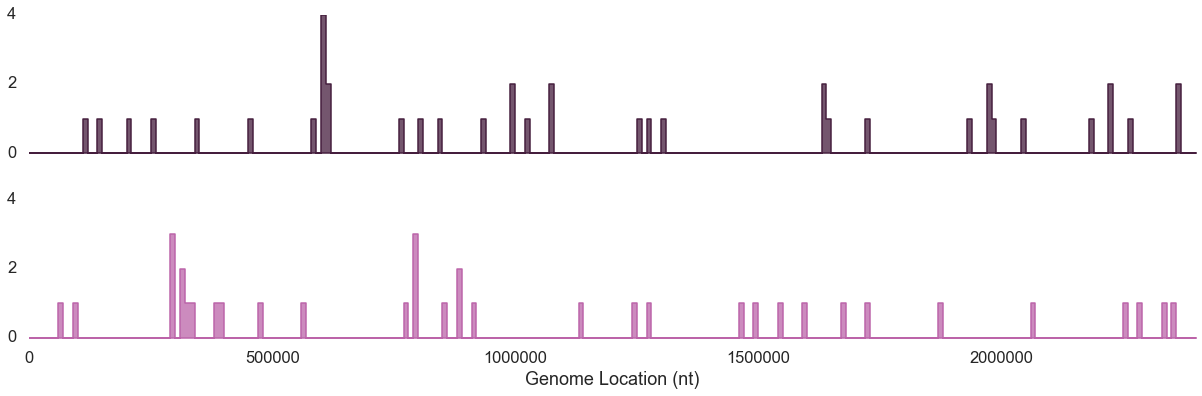

In [169]:
sns.set_context('talk')
species = 'MIT9313'
t = dfs[species]
t = t.loc[t.type.isin(['CDS'])].groupby(['POS', 'TYPE', 'diff_snp'])['call'].first().reset_index()

t['Mutation_type'] = 'Reference'
t.loc[t.diff_snp, 'Mutation_type'] = 'Evolved'
#t = t.sort_values(by='Impact', key=lambda x: x.map({'HIGH': 0, 'MODERATE': 1, 'LOW': 2, 'MODIFIER': 3 }))
#t = t.drop_duplicates(subset='POS')
#t['type_impact'] = t['Mutation_type'] 
#t.loc[t.Impact.isin(['MODIFIER']),'type_impact'] = 'hide'

sns.displot(data = t, x='POS', kde=False, bins=240, 
            row='Mutation_type',
            #facet_kws=dict(row_order=muorder),
            row_order=muorder,
            hue='Mutation_type',
            hue_order=muorder2,
            palette=mupalette,
            aspect=6,
            height=3,
            legend=False,
            binrange=(0,2.4e6),
            common_bins=True,
            element='step',
            #multiple='stack',
            #{“layer”, “dodge”, “stack”, “fill”}
            
            fill=True,
            ).set_titles(row_template='' #"{row_name}"
                        ).set_ylabels('').set(yticks=[0,2,4])

sns.despine(bottom=True, left=True)

#plt.ylim(0,7)
plt.xlabel('Genome Location (nt)')
plt.xlim(0,2.4e6)
#plt.yticks([])
plt.show()


In [131]:
t.type_impact.value_counts()

Evolved      40
Reference    36
Name: type_impact, dtype: int64

In [94]:
species = 'MIT9313'
t = dfs[species]
t = t.groupby(['POS', 'TYPE', 'diff_snp', 'Annotation', 'type', 'Impact'])['call'].first().reset_index()

t['Mutation_type'] = 'Reference'
t.loc[t.diff_snp, 'Mutation_type'] = 'Evolved'
t = t.sort_values(by='Impact', key=lambda x: x.map({'HIGH': 0, 'MODERATE': 1, 'LOW': 2, 'MODIFIER': 3 }))
t = t.drop_duplicates(subset='POS')
t['mutation_type_impact'] = t['Mutation_type'] + t['Impact']
#t.head()
#pd.__version__

In [95]:
t.groupby(['mutation_type_impact'])['TYPE'].count()

mutation_type_impact
EvolvedHIGH           3
EvolvedLOW            5
EvolvedMODERATE      32
EvolvedMODIFIER      12
ReferenceHIGH        10
ReferenceLOW          4
ReferenceMODERATE    22
ReferenceMODIFIER    13
Name: TYPE, dtype: int64

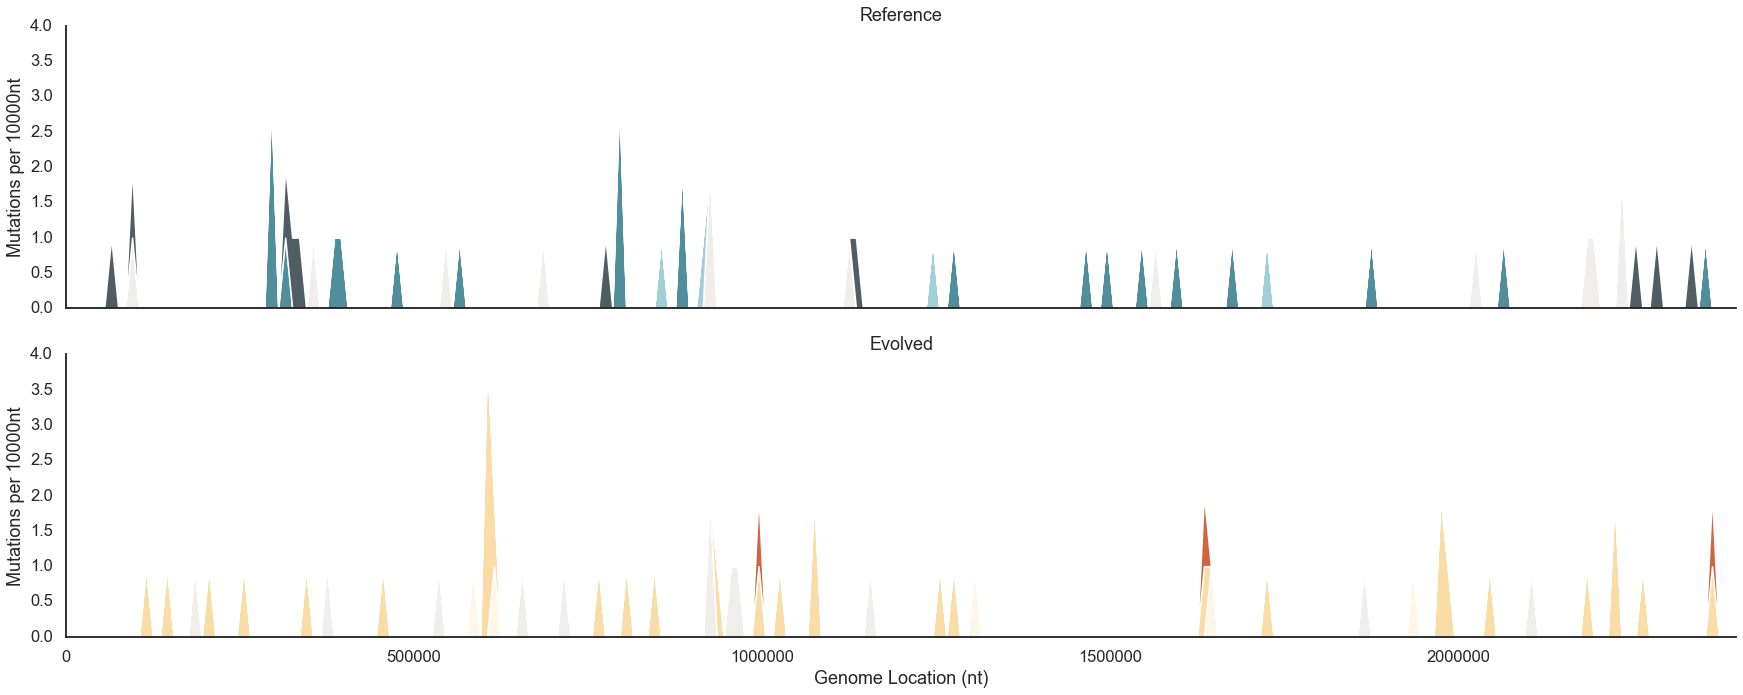

In [96]:
sns.displot(data = t, x='POS', kde=False, bins=240, 
            row='Mutation_type',
            #facet_kws=dict(row_order=muorder),
            hue='mutation_type_impact',
            hue_order=muiorder,
            palette=muipalette,
            aspect=5,
            legend=False,
            binrange=(0,2.4e6),
            common_bins=True,
            element='poly', 
            #element{“bars”, “step”, “poly”}
            multiple='stack',
            #{“layer”, “dodge”, “stack”, “fill”}
            
            fill=True,
            ).set_titles(row_template="{row_name}").set_ylabels('Mutations per 10000nt')

#sns.despine(bottom=True, left=True)

#plt.ylim(0,7)
plt.xlabel('Genome Location (nt)')
plt.xlim(0,2.4e6)
#plt.yticks([])
plt.show()


C:\Users\Osnat\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Osnat\Anaconda3\lib\site-packages\seaborn\distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
C:\Users\Osnat\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Osnat\Anaconda3\lib\site-packages\seaborn\distr

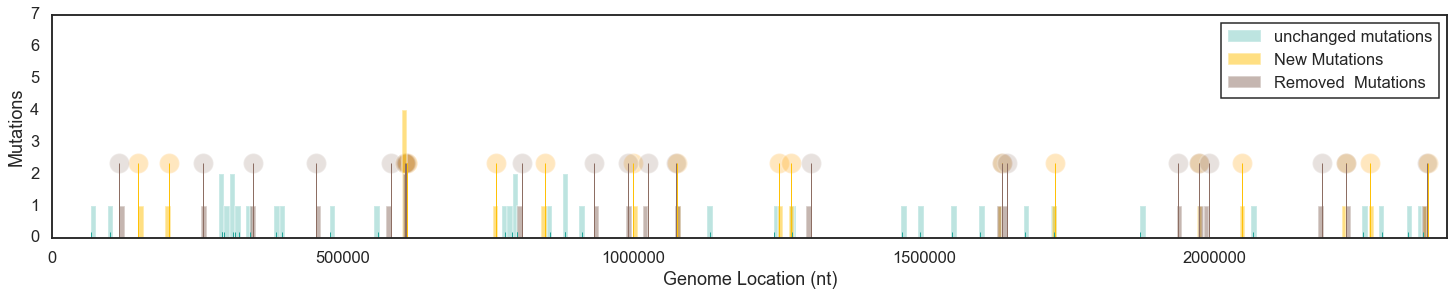

In [92]:
species = 'MIT9313'
t = dfs[species]
t = t.loc[t.type.isin(['CDS'])].groupby(['POS', 'TYPE', 'diff_snp', 'days'])['call'].first().reset_index()
t = t.loc[t.days == 0]

t1= t.loc[~t.diff_snp]
t2= t.loc[t.diff_snp & (t.call == 0)]
t3= t.loc[t.diff_snp & (t.call == 1)]
plt.figure(figsize=(25,4))


sns.distplot(t1['POS'], kde=False, bins=240, hist_kws=dict(alpha=0.3), rug=True, color='#26A69A', label='unchanged mutations')
sns.distplot(t2['POS'], kde=False, bins=240, hist_kws=dict(alpha=0.5), rug=True,
             color='#FFC107', rug_kws=dict(height=1/3), label='New Mutations')
sns.distplot(t3['POS'], kde=False, bins=240, hist_kws=dict(alpha=0.5), rug=True,
             color='#8D6E63', rug_kws=dict(height=1/3), label='Removed  Mutations')

#sns.rugplot(t.POS, height=0.1)
#sns.rugplot(t2.POS, height=0.5, color='Orange')
sns.scatterplot(x=t2.POS, y=7/3, s=400, color='#FFA000', alpha=0.25)
sns.scatterplot(x=t3.POS, y=7/3, s=400, color='#A1887F', alpha=0.25)

glicine_region = (605826, 610831)
#plt.plot(glicine_region[0],10, glicine_region[1],10, marker='o',color='green' )
plt.ylim(0,7)
plt.xlabel('Genome Location (nt)')
plt.ylabel('Mutations')
plt.xlim(0,2.4e6)
#plt.yticks([])
plt.show()


In [ ]:
species = 'MIT9313'
t = dfs[species]
t = t.loc[t.type.isin(['CDS'])].groupby(['POS', 'TYPE', 'diff_snp', 'days'])['call'].first().reset_index()
t = t.loc[t.days == 0]

t.loc[~t.diff_snp, 'Mutation'] = 'Mutation vs Ancestor'
t.loc[t.diff_snp & (t.call == 0), 'Mutation'] = 'Mutation vs parent'
t.loc[t.diff_snp & (t.call == 1), 'Mutation'] = 'Lost Mutation'
t['a'] = 1
sns.relplot(data=t, y='a', hue='Mutation', x='POS', aspect=5, #kind='strip',
            height=3, 
            #order=['New Mutation','Removed Mutation', 'Existing Mutation',], 
            palette=[ '#FFC107', '#A1887F', '#26A69A',],
            s=50, marker="*", 
            edgecolor="gray", #alpha=.5
           )
plt.xlim(0,2.4e6)

In [ ]:
df_genome.type.value_counts()

In [ ]:
species = 'MIT9313'
t = dfs[species]
t.loc[t.type.isin(['CDS'])].groupby(['POS', 'TYPE', 'diff_snp'])['call'].first().reset_index().diff_snp.value_counts()


In [ ]:
number_of_mit9313_cds = 2403
number_of_read_mutations = 41
from scipy.stats import binom 
n = number_of_mit9313_cds
r = number_of_read_mutations
p = 1-1/n
#res = [binom.pmf(k=r, n=n, p=p) for r in range(50)]
#sns.lineplot(x=range(50), y=res)
1 - np.exp(-r*(r-1)/(2*n)) , 1 - ((n - 1)/n)**r

In [ ]:
number_of_mit9313_cds = 2403
number_of_read_mutations = 41
from scipy.stats import binom 
n = number_of_mit9313_cds
r = number_of_read_mutations
p = 1-1/n
res = [1 - np.exp(-r*(r-1)/(2*n)) for r in range(100)]
sns.lineplot(x=range(100), y=res)
#1 - np.exp(-r*(r-1)/(2*n)) , np.sqrt(2*n*np.log(1/(1-1/n)))
plt.xlabel('number of mutations')
plt.ylabel('probability of 2 mutations on the same gene')

In [ ]:
species = 'MIT9313'
t = dfs[species]
t2= t.loc[t.diff_snp]
plt.figure(figsize=(30,9))

#sns.distplot(t['POS'], kde=False, bins=240, hist_kws=dict(alpha=0.3))

sns.rugplot(t.POS, height=0.1)
sns.rugplot(t2.POS, height=0.5, color='Orange')
sns.scatterplot(x=t2.POS, y=0.5, s=100, #hue=t2.Annotation, 
                color='orange'#palette='range', hue=1
               )
glicine_region = (605826, 610831)
plt.plot(glicine_region[0],0.7, glicine_region[1],0.7, marker='o',color='green' 
        )
plt.ylim(0,1)
plt.xlim(0,2.4e6)
plt.yticks([])
plt.show()


In [ ]:
t2.Annotation

In [ ]:
species = 'MIT9313'
pvdf = dfs[species].loc[dfs[species].type == 'CDS'].pivot_table(index=['protein_id', 'gene_id', 'product'], 
                                                columns=[ 'days','sample',], values='call', aggfunc='first')
pvdf = pvdf.reset_index()
pvdf['actual_snp'] = pvdf.std(axis=1) > 1e-1


In [ ]:
pvdf.head()

In [ ]:
protein_ids = pvdf.loc[~pvdf.protein_id.isin(['']), #& pvdf.actual_snp,
                       'protein_id'].unique()


In [ ]:
len(protein_ids)

In [ ]:
pstr = ' '.join([p for p in protein_ids.tolist() if p != ''])

In [ ]:
pstr

In [ ]:
import urllib.parse
import urllib.request
import io

url = 'https://www.uniprot.org/uploadlists/'

params = {
'from': 'P_REFSEQ_AC',
'to': 'ACC',
'format': 'tab',
'query': pstr
}

data = urllib.parse.urlencode(params)
data = data.encode('utf-8')
req = urllib.request.Request(url, data)
with urllib.request.urlopen(req) as f:
   response = f.read()
pid2unip_df = pd.read_csv(io.StringIO(response.decode('utf-8')), sep='\t')



In [ ]:
import urllib.parse
import urllib.request
import io

url = 'https://www.uniprot.org/uploadlists/'

params = {
'from': 'UPARC',
'to': 'ACC',
'format': 'tab',
'query': '\n'.join(pid2unip_df.To.unique().tolist())
}

data = urllib.parse.urlencode(params)
data = data.encode('utf-8')
req = urllib.request.Request(url, data)
with urllib.request.urlopen(req) as f:
   response = f.read()
acc2id_df = pd.read_csv(io.StringIO(response.decode('utf-8')), sep='\t')



In [ ]:
acc2id_df.index = acc2id_df.From
pid2unip_df.loc[pid2unip_df.To.isin(acc2id_df.From), 'To'] = \
    pid2unip_df.loc[pid2unip_df.To.isin(acc2id_df.From), 'To'].map(acc2id_df.To)


In [ ]:
pid2unip_df.shape

In [ ]:
unip_lst = 'accession:' + ' OR accession:'.join(pid2unip_df.To.unique().tolist())
unip_lst

In [ ]:
url = 'https://www.uniprot.org/uniprot/'
columns =  ['id','entry name','protein names','genes','organism','length',
            'go(biological process)','go(cellular component)',
    'go(molecular function)']

params = {
    'query' : unip_lst,
    'format' : 'tab',
    'columns' : ','.join(columns),
    'compress' : 'no',
}

data = urllib.parse.urlencode(params)
data = data.encode('utf-8')
req = urllib.request.Request(url, data)
with urllib.request.urlopen(req) as f:
   response = f.read()
uni2go_df = pd.read_csv(io.StringIO(response.decode('utf-8')), sep='\t')



In [ ]:
uni2go_df.shape

In [ ]:
uni2go_df = uni2go_df.loc[uni2go_df['Organism'].isin(['Prochlorococcus marinus (strain MIT 9313)'])]

uni2go_df.columns

In [ ]:
uni2go_df.shape

In [ ]:
uni_df = pd.merge(pid2unip_df, uni2go_df, left_on='To', right_on='Entry', how='right')
uni_df = pd.merge(pvdf.droplevel(axis=1, level=1).loc[pvdf.actual_snp], uni_df, left_on='protein_id', right_on='From', how='left')

In [ ]:
uni_df.shape

In [ ]:
uni_df.head()

In [ ]:
uni_df.columns

In [ ]:
dfs[species].loc[dfs[species].type.isin(['CDS'])].diff_snp.value_counts()

In [ ]:
all_cols = ['CHROM', 'POS', 'TYPE', 'REF', 'ALT_x', 'species', 'Allele',
       'Annotation', 'Impact', 'Gene_Name', 'Gene_ID', 'Feature_Type',
       'Feature_ID', 'Transcript_BioType', 'Rank', 'HGVS.c', 'HGVS.p',
       'cDNA.pos', 'CDS.pos', 'AA.pos', 'Distance', 'ERRORS', 'sample_number',
       'AO', 'DP', 'RO', 'fraction_Alt', 'culture', 'gene_id', 'pmt_id',
       'type', 'strand', 'product', 'pmt_id', 'PMTID2', 'Synonym', 'q Value ',
       'log Fold Change', 'sample', 'PRO', 'ALT_y', 'exp',
       'days', 'ng/ul', 'final volume']
 

uni_cols = [                   
                                  'gene_id',
                               'Entry name',
                            'Protein names',
                               'Gene names',
                                 'Organism',
                                   'Length',
       'Gene ontology (biological process)',
       'Gene ontology (cellular component)',
       'Gene ontology (molecular function)',
]

    
index_cols = ['CHROM', 'POS', 'TYPE', 'REF', 'ALT_x', 'Annotation', 'Impact',
              'HGVS.p', 'HGVS.c', 'CDS.pos', 'AA.pos',
              'gene_id', 
                                             'Entry name',
                               'Gene names','pmt_id',
                            'Protein names','product',
              'diff_snp',
#                                 'Organism',
                                   'Length',
#       'Gene ontology (biological process)',
#       'Gene ontology (cellular component)',
#       'Gene ontology (molecular function)',
     #'type', 
              'strand', ]
additional_index_cols = ['q Value ', 'log Fold Change',]

column_cols = ['PRO', 'ALT_y', 'days','sample', ]
value_cols = ['call', 'fraction_Alt', #'DP', 'AO', 'RO','GQ','GT',  
             ]
species= 'MIT9313'

toprint_df = pd.merge(dfs[species].loc[dfs[species]['type'].isin(['CDS']) 
                                       #& dfs[species]['gene_id'].isin(uni_df['gene_id'])
                                      ],
                      uni_df[uni_cols], 
                      on='gene_id', how='left', suffixes=('', '_y'),)

condition_format_cols = {
    'MIT9313' : ['X7:AB10000', 'AC7:AG10000' ],
    'MIT0604' : ['R7:AD10000', 'AE7:AQ10000' ],
    '1A3' : ['R7:AB10000', 'AC7:AM10000' ],
    'DE' : ['R7:X20000', 'Y7:AE10000' ],
    
}  
fraction_cols = {
    'MIT9313' :  'AC:AG',
    'MIT0604' :  'AE:AQ',
    '1A3' : 'AC:AM' ,
    'DE' :  'Y:AE' ,
    
}  


#agg_f = lambda x : ' | '.join(x.unique())
with pd.ExcelWriter('var_calls_5x5_MIT9313_uniprot.xlsx', engine='xlsxwriter') as writer:  
    workbook  = writer.book
    format1 = workbook.add_format({'num_format': '#,##0.00'})
    format2 = workbook.add_format({'num_format': '0%'})
    # Light red fill with dark red text.
    format_red = workbook.add_format({'bg_color':   '#FFC7CE',
                                   'font_color': '#9C0006'})

    # Light yellow fill with dark yellow text.
    format_yellow = workbook.add_format({'bg_color':   '#FFEB9C',
                                   'font_color': '#9C6500'})

    # Green fill with dark green text.
    format_green = workbook.add_format({'bg_color':   '#C6EFCE',
                                   'font_color': '#006100'})
    #for species, col in zip(['MIT9313', 'MIT0604', '1A3', 'DE'], ['PRO', 'PRO', 'ALT_y', 'ALT_y']):
    for species, col in zip(['MIT9313'], ['PRO']):
        actual_index_cols = index_cols
        if species == 'MIT9313':
            actual_index_cols = index_cols + additional_index_cols
        excel_pdf = toprint_df.fillna('').pivot_table(
            index=actual_index_cols, columns=column_cols,
            aggfunc='first', margins=False, values=value_cols,
            fill_value='',
        ).reindex(columns=value_cols, level=0,
        ).reindex(columns=['Axenic', '1A3', 'DE'], level='ALT_y',
        ).reindex(columns=['Axenic', 'MIT9313', 'MIT0604'], level='PRO',).reset_index()
        #excel_pdf = excel_pdf.loc[excel_pdf['call'].replace('',np.NaN).std(axis=1) != 0]
        sheetname = f'{species} calls'
        excel_pdf.to_excel(writer, sheet_name=sheetname)
        worksheet = writer.sheets[sheetname]
        worksheet.set_column(fraction_cols[species], None, format1)
        if species == 'MIT9313':
            worksheet.set_column('U:V', None, format1)
        worksheet.set_column('Q:R', 30)  # Col 1 has format1.
        worksheet.set_column('G:G', 12)  # Col 1 has format1.
                
        worksheet.conditional_format(condition_format_cols[species][0], 
                                     {'type': '2_color_scale',                               
                                      'min_color': '#b7efcd', 
                                    #  'mid_color': 'yellow', 
                                      'max_color': '#ffbcbc'
                                     })
        worksheet.conditional_format(condition_format_cols[species][1],  
                                     {'type': '2_color_scale',                               
                                      'min_color': 'white', 
                                    #  'mid_color': 'yellow', 
                                      'max_color': '#f69e7b'
                                     })
        worksheet.conditional_format('B7:S1000' ,
                                     {'type':     'formula',
                                      'criteria': '$S7="TRUE"',
                                      'format':   format_yellow
    })
        #worksheet.conditional_format(f'K1:L{bamqc_df.shape[0]+2}', {'type': 'data_bar', 'bar_color' : 'green'})


In [ ]:
toprint_df.columns

In [ ]:
toprint_df.diff_snp.value_counts()

In [ ]:
dfs[species].loc[dfs[species]['type'].isin(['CDS'])].columns

In [ ]:
dfs[species].loc[dfs[species]['type'].isin(['CDS']) & dfs[species]['call'].isin([1])].dropna(subset=['call']).pivot_table(
    index=['sample'], columns=['diff_snp', 'days', ], values='POS', aggfunc='count')

In [ ]:
dfs[species].loc[dfs[species]['type'].isin(['CDS']) & dfs[species]['call'].isin([0])].dropna(subset=['call']).pivot_table(
    index=['sample'], columns=['diff_snp', 'days', ], values='POS', aggfunc='count')

In [ ]:
dfs[species].loc[dfs[species]['type'].isin(['CDS'])].dropna(subset=['call']).groupby('diff_snp').days.value_counts()

In [ ]:
pvdf = dfs[species].loc[dfs[species].type == 'CDS'].pivot_table(index=['diff_snp','POS'], 
                                                columns=[  'sample','days',], values='call', aggfunc='first').reset_index()


In [ ]:
pvdf.head()

In [ ]:
pvdf.columns

In [ ]:
pvdf.groupby(['diff_snp', (  'Axenic',   0)]).sum()

In [ ]:
pvdf.groupby(['diff_snp', (  'Axenic',   0)]).count() - pvdf.groupby(['diff_snp', (  'Axenic',   0)]).sum()

In [ ]:
pvdf.groupby(['diff_snp', ]).count()

In [ ]:
pvdf.groupby(['diff_snp', ]).sum()

In [ ]:
species = 'MIT9313'
pvdf = dfs[species].pivot_table(index=['POS'], 
                                                columns=[ 'days','sample',], values='call', aggfunc='first')
#pvdf = pvdf.reset_index()
pvdf.loc[pvdf.std(axis=1) > 1e-1].shape
good_call_pos = pvdf.loc[pvdf.std(axis=1) > 1e-1].index
good_call_pos
dfs[species]['diff_snp_all'] = False
dfs[species].loc[dfs[species]['POS'].isin(good_call_pos), 'diff_snp_all'] = True
#pvdf.shape


In [ ]:
dfs[species]['diff_snp_all'].value_counts()


In [ ]:
pvdf = dfs[species].pivot_table(index=['diff_snp_all','POS'], 
                                                columns=[  'sample','days',], values='call', aggfunc='first').reset_index()


In [ ]:
pvdf.head()

In [ ]:
pvdf.columns

In [ ]:
pvdf.groupby(['diff_snp_all', (  'Axenic',   0)]).sum()

In [ ]:
pvdf.groupby(['diff_snp_all', (  'Axenic',   0)]).count() - pvdf.groupby(['diff_snp_all', (  'Axenic',   0)]).sum()

In [ ]:
pvdf.groupby(['diff_snp_all', ]).count()

In [ ]:
pvdf.groupby(['diff_snp_all', ]).sum()

In [ ]:
pvdf.sum()

# go terms

In [ ]:
mdf = uni2go_df.melt(
    id_vars=['Entry', 'Entry name', 'Protein names', 'Gene names', 'Organism', 'Length'],
    value_name='GO term',
    var_name='GO aspect',
).dropna(subset=['GO term'],axis=0).reset_index(drop=True)

In [ ]:
mdf.head()

In [ ]:
s = mdf['GO term'].str.split('; ', expand=True).stack()
i = s.index.get_level_values(0)
df2 = mdf.loc[i].copy()
df2["GO term"] = s.values
df2[["GO term", 'GOid']] = df2["GO term"].str.split(r' \[', expand=True)
df2['GOid'] = df2['GOid'].str.replace(']', '')

In [ ]:
import requests, sys
import json
goterms = df2['GOid'].unique().tolist()
termsstr = ','.join(goterms)

requestURL = f"https://www.ebi.ac.uk/QuickGO/services/ontology/go/terms/{termsstr}/ancestors?relations=is_a%2Cpart_of%2Coccurs_in%2Cregulates"

r = requests.get(requestURL, headers={ "Accept" : "application/json"})

if not r.ok:
  r.raise_for_status()
  sys.exit()

responseBody = r.text
#print(responseBody)
json_rec = json.loads(responseBody)


In [ ]:
ancestor_ids = {j for i in json_rec['results']for j in i['ancestors'] }

In [ ]:
len(ancestor_ids)

In [ ]:
import requests, sys

ancestorsstr = ','.join(ancestor_ids)
requestURL = f"https://www.ebi.ac.uk/QuickGO/services/ontology/go/terms/{ancestorsstr}"

r = requests.get(requestURL, headers={ "Accept" : "application/json"})

if not r.ok:
  r.raise_for_status()
  sys.exit()

responseBody = r.text
ancestor_json_rec = json.loads(responseBody)
ancestor_json_rec
ancestor_names = []
ancestor_names = {i['id'] : i['name'] for i in ancestor_json_rec['results'] }


In [ ]:
ancestors = [
    {'GOid': i['id'],
     'ancestorID': j,
     'ancestor GO term' : ancestor_names[j]
    } for i in json_rec['results']for j in i['ancestors'] ]



In [ ]:
df2.head()

In [ ]:
df2 = pd.merge(df2, pd.DataFrame(ancestors), on='GOid', how='left')

In [ ]:
df2.drop_duplicates(['Entry name', 'GO aspect', 'GO term']).groupby(['GO aspect', 'GO term'])['Entry'].count().reset_index().nlargest(10, 'Entry')

In [ ]:
df2.drop_duplicates(['Entry name', 'GO aspect',  'ancestor GO term']).groupby(['GO aspect',  'ancestor GO term'])['Entry'].count().reset_index().nlargest(60, 'Entry')

In [ ]:
species = 'MIT9313'
pvdf = dfs[species].loc[dfs[species].type == 'CDS'].pivot_table(index=['protein_id', 'gene_id', 'product'], 
                                                columns=[ 'days','sample',], values='call', aggfunc='first')
pvdf = pvdf.reset_index()
pvdf['actual_snp'] = pvdf.std(axis=1) > 1e-1



In [ ]:
go_df = pd.merge(pid2unip_df, df2, left_on='To', right_on='Entry', how='right')
go_df = pd.merge(pvdf.droplevel(axis=1, level=1), go_df, left_on='protein_id', right_on='From', how='left')

In [ ]:
# remove pseudo genes
go_df = go_df.loc[go_df.protein_id != '']
go_df.head(10)

In [ ]:
go_df.loc[go_df['Entry name'].isna()
          , ['protein_id', 'gene_id', 'product']]
#print('\n'.join(go_df.loc[go_df['Entry name'].isna() , ]['protein_id'].unique().tolist()))

In [ ]:
print( 'Total number of genes with SNP')
go_df[['gene_id','protein_id', 'To', 'Entry name', 'actual_snp']
     ].drop_duplicates(['gene_id','actual_snp']).groupby('actual_snp')['gene_id'].count()

In [ ]:
print('Genes with SNP, that have uniprot and go terms')
go_df[['gene_id','protein_id', 'To', 'Entry name', 'actual_snp']
     ].drop_duplicates(['gene_id', 'actual_snp']).groupby('actual_snp')['To'].count()

In [ ]:
go_df.drop_duplicates(['Entry name', 'GO aspect', 'GO term', 'actual_snp']
                   ).pivot_table(index=['GO aspect', 'GO term', ], columns=['actual_snp',], 
                                 values=['Entry'], aggfunc='count').reset_index().nlargest(10, ('Entry', True))

In [ ]:
go_df.drop_duplicates(['Entry name', 'GO aspect', 'ancestor GO term', 'actual_snp']
                   ).pivot_table(index=['GO aspect', 'ancestor GO term', ], columns=['actual_snp',], 
                                 values=['Entry'], aggfunc='count').reset_index().nlargest(15, ('Entry', True))

In [ ]:
go_df.head()

In [ ]:
go_df.columns

In [ ]:
found_goterms =  go_df.loc[go_df.actual_snp].drop_duplicates(['protein_id', 'Entry name', 'GO term'])[
    ['Entry name',  'gene_id', 'product',  'GO aspect', 'GO term', 'GOid', ]].dropna()
found_ancestors_goterms =  go_df.loc[go_df.actual_snp].drop_duplicates(['protein_id', 'Entry name', 'ancestor GO term'])[
    ['Entry name', 'gene_id', 'product', 'GO aspect', 'ancestor GO term', 'ancestorID', ]].dropna()
all_goterms =  all_go_df.loc[~all_go_df['Entry name'].isin(go_df.loc[go_df.actual_snp, 'Entry name'])
                            ].drop_duplicates(['Entry name', 'GO term'])[
    ['Entry name', 'GO aspect', 'GO term', 'GOid', ]].dropna()
all_ancestors_goterms =  all_go_df.loc[~all_go_df['Entry name'].isin(go_df.loc[go_df.actual_snp, 'Entry name'])
                                      ].drop_duplicates(['Entry name', 'ancestor GO term'])[
    ['Entry name', 'GO aspect', 'ancestor GO term', 'ancestorID', ]].dropna()

In [ ]:
found_goterms.columns, found_ancestors_goterms.columns

In [ ]:
found_ancestors_goterms.rename(columns={'ancestor GO term' : 'GO term', 'ancestorID': 'GOid'}, inplace=True)
all_ancestors_goterms.rename(columns={'ancestor GO term' : 'GO term', 'ancestorID': 'GOid'}, inplace=True)


In [ ]:
found_goterms1 = pd.concat([found_goterms, found_ancestors_goterms]).drop_duplicates(['Entry name', 'GO term'])
all_goterms1 = pd.concat([all_goterms, all_ancestors_goterms]).drop_duplicates(['Entry name', 'GO term'])


In [ ]:
found_goterms1.head()

In [ ]:
total_snp_entries = found_goterms1.groupby(['GO aspect'])['Entry name'].nunique()
found_counts = found_goterms1.groupby(
    ['GO aspect', 'GO term', 'GOid']
)['Entry name'].count().reset_index().rename(columns={'Entry name': 'SNP count'})
found_counts['rest SNP count'] =found_counts['GO aspect'].map(total_snp_entries) - found_counts['SNP count'] 

In [ ]:
total_all_entries = all_goterms1.groupby(['GO aspect'])['Entry name'].nunique()
all_counts = all_goterms1.groupby(
    ['GO aspect', 'GO term', 'GOid']
)['Entry name'].count().reset_index().rename(columns={'Entry name': 'all count'})
all_counts['rest all count'] =total_all_entries - all_counts['all count'] 
all_counts['rest all count'] =all_counts['GO aspect'].map(total_all_entries) - all_counts['all count'] 

In [ ]:
go_stats_df = pd.merge(found_counts, all_counts, 
                       on=['GO aspect', 'GO term', 'GOid'],
                      how='left'
                      )

In [ ]:
go_stats_df['all count'] = go_stats_df['all count'].fillna(value=0)
go_stats_df['rest all count'] =go_stats_df['GO aspect'].map(total_all_entries) - go_stats_df['all count'] 


In [ ]:
go_stats_df.head()

In [ ]:
go_stats_df['GO aspect'].value_counts()

In [ ]:
go_stats_df['SNP count'].value_counts()

In [ ]:
MF_stats_df  = go_stats_df.loc[
    go_stats_df['GO aspect'].isin(['Gene ontology (molecular function)']) #& 
    #(go_stats_df['SNP count'] > 2)
]

In [ ]:
MF_stats_df.shape

In [ ]:
pd.reset_option('display.float_format')
def _runfisher(x):
    oddsratio, pvalue = stats.fisher_exact(
        [[x['SNP count'], x['all count']], 
         [x['rest SNP count'], x['rest all count']]],
    alternative='greater'
    )
    return pd.Series([oddsratio, pvalue ])
MF_stats_df[['oddsratio','pvalue']] =  MF_stats_df.apply(_runfisher, axis=1)


In [ ]:
MF_stats_df.nsmallest(30, 'pvalue')

In [ ]:
BP_stats_df  = go_stats_df.loc[
    go_stats_df['GO aspect'].isin(['Gene ontology (biological process)']) #& 
    #(go_stats_df['SNP count'] > 2)
]

In [ ]:
BP_stats_df.shape

In [ ]:
pd.reset_option('display.float_format')
def _runfisher(x):
    oddsratio, pvalue = stats.fisher_exact(
        [[x['SNP count'], x['all count']], 
         [x['rest SNP count'], x['rest all count']]],
    alternative='greater'
    )
    return pd.Series([oddsratio, pvalue ])
BP_stats_df[['oddsratio','pvalue']] =  BP_stats_df.apply(_runfisher, axis=1)


In [ ]:
BP_stats_df.nlargest(20, 'SNP count')

In [ ]:
BP_stats_df.nsmallest(30, 'pvalue')

In [ ]:
BP_stats_df.to_csv('BP_stats.csv')

In [ ]:
go_df.loc[go_df['Entry name'] == 'LEPA_PROMM']

In [ ]:
dfs[species].head()

In [ ]:
species = 'MIT9313'
dfs[species].loc[(dfs[species].type == 'CDS') & (dfs[species].good_call)].groupby('Gene_Name')['product'].first()

In [ ]:
len(go_df.loc[go_df.actual_snp].gene_id.unique())

In [ ]:
ids_with_BP = go_df.loc[go_df['GO aspect'].isin(['Gene ontology (biological process)']) & go_df.actual_snp, 'gene_id'].unique()


In [ ]:
ids_with_BP

In [ ]:
with pd.option_context("display.max_colwidth", 100):
 display(go_df.loc[~go_df.gene_id.isin(ids_with_BP) & go_df.actual_snp #& go_df['Entry name'].isna()
                  ].pivot_table(
    index='gene_id', values=['product', 'Entry name', 'protein_id'], aggfunc='first')#.reset_index()#['protein_id']
        )

In [ ]:
with pd.option_context("display.max_colwidth", 100):
    display(go_df.loc[~go_df.gene_id.isin(ids_with_BP) & go_df.actual_snp].groupby(['gene_id'])['Entry name'].first().reset_index())

In [ ]:
go_df.loc[go_df['Entry name'].isin(['LEPA_PROMM'])]

In [ ]:
for i in found_goterms1['GO aspect'].dropna().unique():
    pvdf = found_goterms1.loc[found_goterms1['GO aspect'].isin([i])
                    ].pivot_table(index=[#'GO aspect',
                                                      'GO term'], 
                                               columns=['Entry name', 'product'], 
                                               values='GO aspect', aggfunc='count',
                                               fill_value=0
                                          )
    print (i, pvdf.shape)
    sns.set_context('talk')
    sns.clustermap(data=pvdf.loc[pvdf.sum(axis=1)>2], figsize=(20,20),) #, col_cluster=False) #, figsize=(20,20), col_cluster=False)
    plt.suptitle(i)
    plt.show()

In [ ]:
for i in found_goterms1['GO aspect'].dropna().unique():
    pvdf = found_goterms1.loc[found_goterms1['GO aspect'].isin([i])
                    ].pivot_table(index=[#'GO aspect',
                                                      'GO term'], 
                                               columns=['Entry name', 'product'], 
                                               values='GO aspect', aggfunc='count',
                                               fill_value=0
                                          )
    print (i, pvdf.shape)
    sns.set_context('talk')
    sns.clustermap(data=pvdf, #.loc[pvdf.sum(axis=1)>2], 
                   figsize=(20,30),) #, col_cluster=False) #, figsize=(20,20), col_cluster=False)
    plt.suptitle(i)
    plt.show()

In [ ]:
pvdf.to_excel('varcall_goterms.xlsx')

In [ ]:
go_df.groupby(['gene_id', 'actual_snp'])['Entry name'].first()

In [ ]:
for i in go_df['GO aspect'].dropna().unique():
    pvdf = go_df.loc[go_df['GO aspect'].isin([i])
                    ].drop_duplicates(['gene_id', 'actual_snp','GO term'])
    sns.set_context('paper')
    sns.catplot(data=pvdf, y='GO term', hue='actual_snp', kind='count', height=15)
    plt.title(i)
    plt.show()

In [ ]:
for i in go_df['GO aspect'].dropna().unique():
    pvdf = go_df.loc[go_df['GO aspect'].isin([i])
                    ].drop_duplicates(['gene_id', 'actual_snp','GO term'])
    sns.set_context('paper')
    sns.catplot(data=pvdf, y='ancestor GO term', hue='actual_snp', kind='count', height=15)
    plt.title(i)
    plt.show()

In [ ]:
for i in go_df['GO aspect'].dropna().unique():
    pvdf = go_df.loc[go_df['GO aspect'].isin([i])
                    ].drop_duplicates(['gene_id', 'actual_snp','GO term']
                                 ).pivot_table(index=[#'GO aspect',
                                                      'GO term'], 
                                               columns=['actual_snp','gene_id'], 
                                               values='protein_id', aggfunc='count',
                                               fill_value=0
                                          )
    print (i, pvdf.shape)
    pvdf = pvdf.droplevel(axis=1, level=1)
    sns.set_context('paper')
    lut = dict(zip(go_df['actual_snp'].unique(), "rg"))
    col_colors = pvdf.columns.map(lut)
    sns.clustermap(data=pvdf.loc[pvdf.sum(axis=1) >0], 
                   linewidths=0.03, 
                  col_colors=col_colors
                  )
                  #, col_cluster=False) #, figsize=(20,20), col_cluster=False)
    plt.suptitle(i)
    plt.show()

In [ ]:
for i in go_df['GO aspect'].dropna().unique():
    pvdf = go_df.loc[go_df['GO aspect'].isin([i])
                    ].drop_duplicates(['gene_id', 'actual_snp','GO term']
                                 ).pivot_table(index=[#'GO aspect',
                                                      'GO term'], 
                                               columns=['actual_snp','gene_id'], 
                                               values='protein_id', aggfunc='count',
                                               fill_value=0
                                          )
    print (i, pvdf.shape)
    pvdf = pvdf.droplevel(axis=1, level=1)
    sns.set_context('paper')
    plt.suptitle(i)
    lut = dict(zip(go_df['actual_snp'].unique(), "rg"))
    col_colors = pvdf.columns.map(lut)
    sns.clustermap(data=pvdf.loc[pvdf.sum(axis=1) >1], 
                   linewidths=0.03, 
                  col_colors=col_colors
                  )
                  #, col_cluster=False) #, figsize=(20,20), col_cluster=False)
    plt.show()

In [ ]:
for i in go_df['GO aspect'].dropna().unique():
    pvdf = go_df.loc[go_df['GO aspect'].isin([i])
                    ].drop_duplicates(['gene_id', 'actual_snp','ancestor GO term']
                                 ).pivot_table(index=[#'GO aspect',
                                                      'ancestor GO term'], 
                                               columns=['actual_snp','gene_id'], 
                                               values='protein_id', aggfunc='count',
                                               fill_value=0
                                          )
    print (i, pvdf.shape)
    pvdf = pvdf.droplevel(axis=1, level=1)
    sns.set_context('paper')
    plt.suptitle(i)
    lut = dict(zip(go_df['actual_snp'].unique(), "rg"))
    col_colors = pvdf.columns.map(lut)
    sns.clustermap(data=pvdf.loc[pvdf.sum(axis=1) >3], 
                   linewidths=0.03, 
                  col_colors=col_colors
                , col_cluster=False
                  )
    
                  #, col_cluster=False) #, figsize=(20,20), col_cluster=False)
    plt.show()

In [ ]:
for i in go_df['GO aspect'].dropna().unique():
    pvdf = go_df.loc[go_df['GO aspect'].isin([i]) & go_df['actual_snp']
                    ].drop_duplicates(['gene_id', 'ancestor GO term']
                                 ).pivot_table(index=[#'GO aspect',
                                                      'ancestor GO term'], 
                                               columns=[#'actual_snp',
                                                        'gene_id', 'product'], 
                                               values='protein_id', aggfunc='count',
                                               fill_value=0
                                          )
    print (i, pvdf.shape)
    #pvdf = pvdf.droplevel(axis=1, level=1)
    sns.set_context('paper')
    plt.suptitle(i)
    #ut = dict(zip(go_df['actual_snp'].unique(), "rg"))
    #ol_colors = pvdf.columns.map(lut)
    sns.clustermap(data=pvdf, #.loc[pvdf.sum(axis=1) >3], 
                   linewidths=0.03, 
                   #col_colors=col_colors
                #, col_cluster=False
                  )
    
                  #, col_cluster=False) #, figsize=(20,20), col_cluster=False)
    plt.show()

In [ ]:
pvdf.sum(axis=1) >3

In [ ]:
sns.set_context('paper')
sns.clustermap(data=pvdf, figsize=(20,20), col_cluster=False)

In [ ]:
go_df.columns

In [ ]:
pvdf.head()

In [ ]:
os.listdir('DNA')

# Unmapped BLAST

In [ ]:
unmapped_header = ['query id', 'subject id', '% identity', 'alignment length', 'mismatches', 'gap opens', 
                   'q. start', 'q. end', 's. start', 's. end', 'evalue', 'bit score', 
                   'subject tax ids', 'subject sci names'
]
data_dpath = os.path.join('DNA','dnaseq',)
unmapped_df = pd.read_csv(os.path.join(data_dpath,'contigs.fasta.nt.blastn'), 
                          names=unmapped_header, sep='\t', comment='#')

In [ ]:
unmapped_df[['contig', 'contig length', 'contig coverage']] = unmapped_df['query id'].str.split('_', expand=True)[[1,3,5]]
unmapped_df['contig'] = pd.to_numeric(unmapped_df['contig'])

In [ ]:
unmapped_df.head()

In [ ]:
unmapped_df.groupby(['subject sci names']
                   ).agg ({'alignment length': 'sum', 'contig' : 'nunique', 'bit score': 'count'}).nlargest(20, 'alignment length')

In [ ]:
unmapped_header = ['query id', 'subject id', '% identity', 'alignment length', 'mismatches', 'gap opens', 
                   'q. start', 'q. end', 's. start', 's. end', 'evalue', 'bit score', 
                   'subject tax ids', 'subject sci names'
]
unmapped_df = pd.read_csv(os.path.join('DNA', 'dnaseq', 'unmapped.axenic.nt.blastn'), names=unmapped_header, sep='\t', comment='#')
unmapped_df[['contig', 'contig length', 'contig coverage']] = unmapped_df['query id'].str.split('_', expand=True)[[1,3,5]]
unmapped_df['contig'] = pd.to_numeric(unmapped_df['contig'])

In [ ]:
unmapped_df.groupby(['subject sci names']
                   ).agg ({'alignment length': 'sum', 'contig' : 'nunique', 'bit score': 'count'}).nlargest(20, 'alignment length')

In [ ]:
data_dpath = os.path.join('DNA','dnaseq','kraken_unmapped')
def _parse_csv(i):
    fpath = os.path.join(data_dpath, f'{160000+i}.bracken.species.txt')
    df =  pd.read_csv(fpath, sep='\t') 
    df['sample_number'] = i
    return df
tmpdf = [_parse_csv(i) for i in [4] + list(range(10,22))]
kraken_unmapped_gdf =pd.concat(tmpdf)
kraken_unmapped_gdf = pd.merge(kraken_unmapped_gdf, meta_df, on='sample_number', how='left')

In [ ]:
kraken_unmapped_gdf.sample_number.value_counts().sort_index()

In [ ]:
kraken_unmapped_gdf.columns

In [ ]:
plt.figure(figsize=(20,7))
sns.set_context('talk')
common_names = kraken_unmapped_gdf.loc[kraken_unmapped_gdf.fraction_total_reads>0.05, 'name']
pkraken_unmapped_gdf = kraken_unmapped_gdf.loc[kraken_unmapped_gdf.name.isin(common_names)
                                              ].pivot_table(index='name', columns=['sample_number', 'ALT'], 
                                                       values='fraction_total_reads')
sns.heatmap(pkraken_unmapped_gdf*100, cmap='coolwarm', annot=True, vmax=30,
 fmt='.0f',
            linewidths=1, linecolor='white', cbar=False)           
plt.title('% unmapped reads', y=1)

In [ ]:
plt.figure(figsize=(20,7))
sns.set_context('talk')
common_names = kraken_unmapped_gdf.loc[kraken_unmapped_gdf.fraction_total_reads>0.05, 'name']
pkraken_unmapped_gdf = kraken_unmapped_gdf.loc[kraken_unmapped_gdf.name.isin(common_names)
                                              ].pivot_table(index='name', columns=['sample_number', 'ALT'], 
                                                       values='new_est_reads')
sns.heatmap(pkraken_unmapped_gdf, cmap='coolwarm', annot=True, vmax=5000,
 fmt='.0f',
            linewidths=1, linecolor='white', cbar=False)           
            
plt.title('unmapped reads', y=1)

# spades stats

In [ ]:
spades_header = ['Node', 'Length', 'Coverage']
df_spades_all = pd.read_csv(os.path.join('DNA', 'dnaseq', 'unmapped_contigs.txt'), names=spades_header)
df_spades_axenic = pd.read_csv(os.path.join('DNA', 'dnaseq', 'axenic_unmapped_contigs.txt'), names=spades_header)


Any chance it could be a bacteriophage? 
I would recommend performing a de novo assembly both on all the data and also on the unmapped data. 
It would be interesting to look at how the data plot 
(we plot **summed assembly length vs average coverage when sorted from highest coverage to lowest**).


In [ ]:
df_spades_all.sort_values(by='Coverage', ascending=False, inplace=True)
df_spades_all['Summed Assembly Length'] = df_spades_all['Length'].cumsum()
df_spades_all['Average Coverage'] = df_spades_all['Coverage'].expanding().mean()

In [ ]:
df_spades_axenic.sort_values(by='Coverage', ascending=False, inplace=True)
df_spades_axenic['Summed Assembly Length'] = df_spades_axenic['Length'].cumsum()
df_spades_axenic['Average Coverage'] = df_spades_axenic['Coverage'].expanding().mean()

In [ ]:
df_spades_all.head()

In [ ]:
sns.set_context('talk')
sns.relplot(data=df_spades_all, x='Summed Assembly Length', y='Average Coverage',
           kind='line', aspect=1.4)
plt.xlim(-0.1e7,1e7)
plt.ylim(-1000,8000)
plt.title('Unmapped MIT0604 Reads ')

In [ ]:
sns.set_context('talk')
sns.relplot(data=df_spades_axenic, x='Summed Assembly Length', y='Average Coverage', color='green',
           kind='line', aspect=1.4)
plt.xlim(-0.1e7,0.4e7)
plt.ylim(-100,600)
plt.title('Unmapped Axenic MIT0604 Reads ')

In [ ]:
df_spades_all.head(20)

In [ ]:
df_spades_axenic.head(20)

In [ ]:
unmapped_blastx_fpath = os.path.join('DNA', 'dnaseq', 'MIT0604 unmapped-Alignment.xml')
unmapped_axenic_blastx_fpath = os.path.join('DNA', 'dnaseq', 'MIT0604 unmapped axenic-Alignment.xml')

from Bio.Blast import NCBIXML
def _unmapped_blastx_to_rec(blast_rec):
    query_id = blast_rec.query.split('.')[0] #.replace(' unnamed protein product','').replace('lcl|','')
    node_id = int(query_id.split('_')[1])
    results = [{
        'query' : query_id,
        'Node' : node_id,
        'Subject' : a.hit_def,
        'Accession' : d.accession,
        'Qcov': np.round(np.mean([hsp.align_length / blast_rec.query_length for hsp in a.hsps]), decimals=2),
        'Ident': np.round(np.mean([hsp.identities / blast_rec.query_length for hsp in a.hsps]), decimals=2),
        }
        for d,a in zip(blast_rec.descriptions, blast_rec.alignments)
    ]
    return results
fh = open(unmapped_blastx_fpath)
blast_records = NCBIXML.parse(fh)
reslist = [_unmapped_blastx_to_rec(b) for b in blast_records]
unblastx_df = pd.DataFrame([i for lst in reslist for i in lst])
fh.close()
fh = open(unmapped_axenic_blastx_fpath )
blast_records = NCBIXML.parse(fh)
reslist = [_unmapped_blastx_to_rec(b) for b in blast_records]
axblastx_df = pd.DataFrame([i for lst in reslist for i in lst])
fh.close()

In [ ]:
unblastx_df.head()

In [ ]:
unblastx_df = pd.merge(df_spades_all.loc[df_spades_all.Coverage > 50], 
         unblastx_df.drop_duplicates(subset='Node', keep='first'),
         on='Node', how='left')
axblastx_df = pd.merge(df_spades_axenic.loc[df_spades_axenic.Coverage > 20], 
         axblastx_df.drop_duplicates(subset='Node', keep='first'),
         on='Node', how='left')

In [ ]:
with pd.option_context("display.max_colwidth", 100):

    display(unblastx_df[['Node', 'Length', 'Coverage',
        'Subject', 'Accession', 'Qcov', 'Ident']].fillna(''))


In [ ]:
with pd.option_context("display.max_colwidth", 100):

    display(axblastx_df[['Node', 'Length', 'Coverage',
        'Subject', 'Accession', 'Qcov', 'Ident']].fillna(''))


In [ ]:
unblastx_df.columns